# Classification on Botnet DGA Dataset

In [17]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pennylane as qml
from pennylane import numpy as np

from datetime import datetime
import os
import pickle
import time

import qiskit
import qiskit.providers.aer.noise as noise

from qiskit import QuantumCircuit, execute
from qiskit import IBMQ, Aer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

In [18]:
#IBMQ.save_account('412323e770fb2ee81fb9b79d3effe940d0a7f72c3be198a65f580a20b38b00a607ad8c8a9b5322116fc1aee89be55463fe87e7a43da6af415bbaa95236fca521')

## Experiment Settings

In [19]:
import random as python_random
SEED = 123
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)

n_qubits = 2
# dev = qml.device("default.mixed", wires=n_qubits)


#dev = qml.device('qiskit.aer', wires=n_qubits)


# Error probabilities
#prob_1 = 0.001  # 1-qubit gate
#prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
#error_1 = noise.depolarizing_error(prob_1, 1)
#error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
#noise_model = noise.NoiseModel()
#noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
#noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Create a PennyLane device
# dev = qml.device('qiskit.aer', wires=n_qubits, noise_model=noise_model)


# Build noise model from backend properties
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_santiago')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

dev = qml.device('qiskit.aer', wires=n_qubits, backend='qasm_simulator', 
                 coupling_map=coupling_map, basis_gates=basis_gates, noise_model=noise_model)
#                 backend_options={"validation_threshold": 1e-6})


n_layers = 1 #6
num_data = 1000  #1803333
EPOCHS = 10000
BATCH_SIZE = 50 #2048


weight_shapes = {"weights": (n_layers, n_qubits)}

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

now = datetime.now()
results_folder = "RESULTS5-QiskitNoisy/nd1000_nq2_nl1_03-25-2021_14-03-45/"
#"RESULTS5-QiskitNoisy/nd" + str(num_data) + "_" + "nq" + str(n_qubits) + "_" + "nl" + str(n_layers) + "_" + now.strftime("%m-%d-%Y_%H-%M-%S") + "/"
print("results_folder: ",results_folder)
#os.mkdir(results_folder)

f = open(results_folder + "results.txt", "a", encoding='utf-8')
f.write(results_folder + "\n")

mpl.rcParams['savefig.dpi'] = 600

results_folder:  RESULTS5-QiskitNoisy/nd1000_nq2_nl1_03-25-2021_14-03-45/


## Example of a QNode

In [20]:
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

## Data processing and exploration

### Load csv data set

In [21]:
#raw_df = pd.read_csv("dataset/n"+str(num_data)+"_botnetdga_TRAIN.csv")
#raw_df.head()

In [22]:
#raw_df[['Entropy','REAlexa','MinREBotnets','InformationRadius','CharLength','TreeNewFeature','nGramReputation_Alexa','Class']].describe()

### Clean, split and normalize the data

In [23]:
#cleaned_df = raw_df.copy()
#cleaned_df.pop('Entropy')
#cleaned_df.pop('REAlexa')
#cleaned_df.pop('InformationRadius')

In [24]:
#train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
#train_df, val_df = train_test_split(train_df, test_size=0.2)

In [25]:
#train_labels = np.array(train_df.pop('Class'))
#val_labels = np.array(val_df.pop('Class'))
#test_labels = np.array(test_df.pop('Class'))

In [26]:
#train_features = np.array(train_df)
#val_features = np.array(val_df)
#test_features = np.array(test_df)

In [27]:
#scaler = StandardScaler()
#train_features = scaler.fit_transform(train_features)
#val_features = scaler.transform(val_features)
#test_features = scaler.transform(test_features)

In [28]:
#train_features = np.clip(train_features, -5, 5)
#val_features = np.clip(val_features, -5, 5)
#test_features = np.clip(test_features, -5, 5)

## Loads the already prepared benchmark datasets

In [29]:
test_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_test_features.csv") )
test_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_test_labels.csv") )

train_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_train_features.csv") )
train_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_train_labels.csv") )

val_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_val_features.csv") )
val_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_val_labels.csv") )

## Define the model and metrics 

In [30]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          n_qubits, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      qlayer,
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=100,
    mode='max',
    restore_best_weights=True)

In [32]:
def plot_loss(history, label, n, expId):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(results_folder + '_' + str(expId) + '_plot_loss.png', format='png')

    
def plot_metrics(history, expId):
  metrics = ['accuracy', 'loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(5,1,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    plt.savefig(results_folder + '_' + str(expId) + '_plot_metrics.png', format='png')
    
def plot_cm(labels, predictions, expId , p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.savefig(results_folder + '_' + str(expId) + '_plot_cm.png', format='png')

  print('Legitimate Domain Name Detected (True Negatives): ', cm[0][0])
  print('Legitimate Domain Name Incorrectly Detected as Botnet DGA (False Positives): ', cm[0][1])
  print('Botnet DGA Missed (False Negatives): ', cm[1][0])
  print('Botnet DGA Detected (True Positives): ', cm[1][1])
  print('Total Botnet DGAs: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

## Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [33]:
model = make_model()

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

print("initial_weights = ", initial_weights)

initial_weights =  /tmp/tmpjyyu034y/initial_weights


# Experiments A - Hybrid Classical-Quantum DL

In [34]:
def runTheExperiments(expId, desc, model=None):
    
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(SEED)
    python_random.seed(SEED)
    tf.random.set_seed(SEED)

    start_time = time.time()
    f.write("\n\n\n#" + desc + "\n")
    
    if model is None:
        model = make_model()
        model.load_weights(initial_weights)

    history = model.fit(
        train_features,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping],
        validation_data=(val_features, val_labels))

    #model.save(results_folder + 'model_' + str(expId))
    #with open(results_folder + 'history_' + str(expId), 'wb') as file_pi:
    #    pickle.dump(history.history, file_pi)

    train_predictions = model.predict(train_features, batch_size=BATCH_SIZE)
    test_predictions = model.predict(test_features, batch_size=BATCH_SIZE)


    plot_loss(history, "history", 0, expId=expId)

    plot_metrics(history, expId=expId)

    baseline_results = model.evaluate(test_features, test_labels,
                                      batch_size=BATCH_SIZE, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
      print(name, ': ', value)
      f.write(name + ' : \t' + str(value) + "\n")
    print()
    plot_cm(test_labels, test_predictions, expId=expId)

    plot_roc("Train", train_labels, train_predictions, color=colors[0])
    plot_roc("Test", test_labels, test_predictions, color=colors[0], linestyle='--')
    plt.legend(loc='lower right')
    plt.savefig(results_folder + '_' + str(expId) + '_plot_roc.png', format='png')
    
    f.write("--- %s seconds ---" % (time.time() - start_time))  
    f.write("\n\n")
    f.write(qnode.draw())
    f.flush()
    
    tf.keras.utils.plot_model(
    model, to_file=results_folder+'model'+ str(expId) + '.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=600
    )
        
    return model, history
    

## AngleEmbedding

Epoch 1/10000
13/13 [==============================] - 443s 35s/step - loss: 0.7141 - tp: 129.5714 - fp: 166.7857 - tn: 23.7143 - fn: 49.7857 - accuracy: 0.4137 - precision: 0.4340 - recall: 0.7269 - auc: 0.5003 - val_loss: 0.7563 - val_tp: 37.0000 - val_fp: 67.0000 - val_tn: 6.0000 - val_fn: 49.0000 - val_accuracy: 0.2704 - val_precision: 0.3558 - val_recall: 0.4302 - val_auc: 0.2733
Epoch 2/10000
13/13 [==============================] - 471s 36s/step - loss: 0.7207 - tp: 115.2857 - fp: 158.8571 - tn: 33.0714 - fn: 62.6429 - accuracy: 0.3906 - precision: 0.4097 - recall: 0.6504 - auc: 0.4853 - val_loss: 0.7513 - val_tp: 33.0000 - val_fp: 57.0000 - val_tn: 16.0000 - val_fn: 53.0000 - val_accuracy: 0.3082 - val_precision: 0.3667 - val_recall: 0.3837 - val_auc: 0.2700
Epoch 3/10000
13/13 [==============================] - 471s 36s/step - loss: 0.7292 - tp: 96.0714 - fp: 146.5714 - tn: 47.2143 - fn: 80.0000 - accuracy: 0.3781 - precision: 0.3824 - recall: 0.5479 - auc: 0.4042 - val_loss: 

13/13 [==============================] - 475s 37s/step - loss: 0.6206 - tp: 65.6429 - fp: 6.7143 - tn: 185.0714 - fn: 112.4286 - accuracy: 0.6684 - precision: 0.9136 - recall: 0.3406 - auc: 0.6874 - val_loss: 0.6190 - val_tp: 55.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 31.0000 - val_accuracy: 0.7736 - val_precision: 0.9167 - val_recall: 0.6395 - val_auc: 0.8137
Epoch 44/10000
13/13 [==============================] - 475s 37s/step - loss: 0.5902 - tp: 74.2143 - fp: 9.7857 - tn: 183.5000 - fn: 102.3571 - accuracy: 0.7027 - precision: 0.8668 - recall: 0.4303 - auc: 0.7673 - val_loss: 0.6115 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.8397
Epoch 45/10000
13/13 [==============================] - 476s 37s/step - loss: 0.6172 - tp: 75.0000 - fp: 10.7143 - tn: 180.5714 - fn: 103.5714 - accuracy: 0.6856 - precision: 0.8725 - recall: 0.4123 - auc: 0.7195 - val_loss: 0.6108 - val_t

13/13 [==============================] - 475s 37s/step - loss: 0.5703 - tp: 81.2857 - fp: 9.0000 - tn: 184.6429 - fn: 94.9286 - accuracy: 0.7201 - precision: 0.9053 - recall: 0.4522 - auc: 0.7602 - val_loss: 0.5668 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.8268
Epoch 86/10000
13/13 [==============================] - 475s 37s/step - loss: 0.5621 - tp: 90.9286 - fp: 8.8571 - tn: 177.0714 - fn: 93.0000 - accuracy: 0.7212 - precision: 0.9141 - recall: 0.4927 - auc: 0.7738 - val_loss: 0.5654 - val_tp: 61.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 25.0000 - val_accuracy: 0.8176 - val_precision: 0.9385 - val_recall: 0.7093 - val_auc: 0.8488
Epoch 87/10000
13/13 [==============================] - 477s 37s/step - loss: 0.5813 - tp: 77.7143 - fp: 11.2143 - tn: 178.4286 - fn: 102.5000 - accuracy: 0.6926 - precision: 0.8653 - recall: 0.4419 - auc: 0.7418 - val_loss: 0.5645 - val_tp:

13/13 [==============================] - 476s 37s/step - loss: 0.5582 - tp: 90.9286 - fp: 12.2143 - tn: 174.5000 - fn: 92.2143 - accuracy: 0.7230 - precision: 0.8905 - recall: 0.5150 - auc: 0.7595 - val_loss: 0.5446 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.8663
Epoch 128/10000
13/13 [==============================] - 476s 37s/step - loss: 0.5639 - tp: 90.0714 - fp: 10.4286 - tn: 179.8571 - fn: 89.5000 - accuracy: 0.7255 - precision: 0.8949 - recall: 0.5016 - auc: 0.7438 - val_loss: 0.5452 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.8617
Epoch 129/10000
13/13 [==============================] - 476s 37s/step - loss: 0.5642 - tp: 91.4286 - fp: 9.2143 - tn: 175.2857 - fn: 93.9286 - accuracy: 0.7198 - precision: 0.9217 - recall: 0.4977 - auc: 0.7264 - val_loss: 0.5398 - val_t

13/13 [==============================] - 477s 37s/step - loss: 0.5455 - tp: 91.8571 - fp: 9.0714 - tn: 181.9286 - fn: 87.0000 - accuracy: 0.7377 - precision: 0.9260 - recall: 0.5058 - auc: 0.7663 - val_loss: 0.5294 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.8724
Epoch 170/10000
13/13 [==============================] - 476s 37s/step - loss: 0.5355 - tp: 96.5714 - fp: 10.7143 - tn: 183.6429 - fn: 78.9286 - accuracy: 0.7549 - precision: 0.8825 - recall: 0.5486 - auc: 0.7663 - val_loss: 0.5279 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.8965
Epoch 171/10000
13/13 [==============================] - 476s 37s/step - loss: 0.5114 - tp: 95.1429 - fp: 7.7143 - tn: 186.7857 - fn: 80.2143 - accuracy: 0.7732 - precision: 0.9260 - recall: 0.5650 - auc: 0.8074 - val_loss: 0.5297 - val_tp

13/13 [==============================] - 477s 37s/step - loss: 0.5109 - tp: 100.3571 - fp: 3.6429 - tn: 187.5000 - fn: 78.3571 - accuracy: 0.7692 - precision: 0.9661 - recall: 0.5408 - auc: 0.7888 - val_loss: 0.5137 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9203
Epoch 212/10000
13/13 [==============================] - 476s 37s/step - loss: 0.5364 - tp: 94.0000 - fp: 12.6429 - tn: 180.7857 - fn: 82.4286 - accuracy: 0.7494 - precision: 0.8926 - recall: 0.5430 - auc: 0.7595 - val_loss: 0.5154 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9024
Epoch 213/10000
13/13 [==============================] - 476s 37s/step - loss: 0.5270 - tp: 105.5714 - fp: 9.9286 - tn: 181.3571 - fn: 73.0000 - accuracy: 0.7729 - precision: 0.9157 - recall: 0.5791 - auc: 0.7498 - val_loss: 0.5143 - val_

13/13 [==============================] - 477s 37s/step - loss: 0.5006 - tp: 99.8571 - fp: 7.1429 - tn: 186.6429 - fn: 76.2143 - accuracy: 0.7748 - precision: 0.9250 - recall: 0.5664 - auc: 0.7695 - val_loss: 0.5093 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9287
Epoch 254/10000
13/13 [==============================] - 477s 37s/step - loss: 0.4794 - tp: 111.7143 - fp: 7.2143 - tn: 182.7143 - fn: 68.2143 - accuracy: 0.8008 - precision: 0.9370 - recall: 0.6258 - auc: 0.7910 - val_loss: 0.5079 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9251
Epoch 255/10000
13/13 [==============================] - 477s 37s/step - loss: 0.4749 - tp: 109.2143 - fp: 7.4286 - tn: 182.1429 - fn: 71.0714 - accuracy: 0.7927 - precision: 0.9384 - recall: 0.6130 - auc: 0.7952 - val_loss: 0.5044 - val_t

13/13 [==============================] - 456s 35s/step - loss: 0.4867 - tp: 107.4286 - fp: 10.0714 - tn: 179.0714 - fn: 73.2857 - accuracy: 0.7762 - precision: 0.9060 - recall: 0.6018 - auc: 0.7912 - val_loss: 0.4977 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9396
Epoch 296/10000
13/13 [==============================] - 455s 35s/step - loss: 0.4892 - tp: 111.9286 - fp: 9.5000 - tn: 181.7857 - fn: 66.6429 - accuracy: 0.7908 - precision: 0.9153 - recall: 0.6276 - auc: 0.8220 - val_loss: 0.4945 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9446
Epoch 297/10000
13/13 [==============================] - 455s 35s/step - loss: 0.4758 - tp: 106.6429 - fp: 7.5714 - tn: 185.0000 - fn: 70.6429 - accuracy: 0.7880 - precision: 0.9409 - recall: 0.5985 - auc: 0.7800 - val_loss: 0.4971 - val

13/13 [==============================] - 455s 35s/step - loss: 0.5105 - tp: 95.3571 - fp: 7.7857 - tn: 192.1429 - fn: 74.5714 - accuracy: 0.7726 - precision: 0.9143 - recall: 0.5482 - auc: 0.7364 - val_loss: 0.4934 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9388
Epoch 338/10000
13/13 [==============================] - 454s 35s/step - loss: 0.5038 - tp: 97.6429 - fp: 7.2143 - tn: 189.2143 - fn: 75.7857 - accuracy: 0.7808 - precision: 0.9399 - recall: 0.5592 - auc: 0.7479 - val_loss: 0.4892 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9442
Epoch 339/10000
13/13 [==============================] - 456s 35s/step - loss: 0.4878 - tp: 112.2143 - fp: 7.0000 - tn: 181.6429 - fn: 69.0000 - accuracy: 0.7851 - precision: 0.9489 - recall: 0.6073 - auc: 0.8080 - val_loss: 0.4901 - val_tp

13/13 [==============================] - 456s 35s/step - loss: 0.4777 - tp: 108.8571 - fp: 4.9286 - tn: 187.2143 - fn: 68.8571 - accuracy: 0.8010 - precision: 0.9597 - recall: 0.6163 - auc: 0.7687 - val_loss: 0.4827 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9436
Epoch 380/10000
13/13 [==============================] - 455s 35s/step - loss: 0.5040 - tp: 97.7857 - fp: 7.7857 - tn: 186.7857 - fn: 77.5000 - accuracy: 0.7682 - precision: 0.9180 - recall: 0.5568 - auc: 0.7674 - val_loss: 0.4835 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9448
Epoch 381/10000
13/13 [==============================] - 457s 35s/step - loss: 0.4532 - tp: 110.6429 - fp: 6.1429 - tn: 188.0000 - fn: 65.0714 - accuracy: 0.8091 - precision: 0.9471 - recall: 0.6366 - auc: 0.8236 - val_loss: 0.4853 - val_t

13/13 [==============================] - 455s 35s/step - loss: 0.4651 - tp: 107.6429 - fp: 4.6429 - tn: 190.2143 - fn: 67.3571 - accuracy: 0.8110 - precision: 0.9606 - recall: 0.6193 - auc: 0.7883 - val_loss: 0.4793 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9423
Epoch 422/10000
13/13 [==============================] - 456s 35s/step - loss: 0.4843 - tp: 109.8571 - fp: 9.2857 - tn: 182.7143 - fn: 68.0000 - accuracy: 0.7841 - precision: 0.9015 - recall: 0.6086 - auc: 0.7820 - val_loss: 0.4766 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9466
Epoch 423/10000
13/13 [==============================] - 455s 35s/step - loss: 0.5302 - tp: 101.2143 - fp: 6.7857 - tn: 176.8571 - fn: 85.0000 - accuracy: 0.7375 - precision: 0.9310 - recall: 0.5353 - auc: 0.7577 - val_loss: 0.4787 - val_

13/13 [==============================] - 456s 35s/step - loss: 0.4800 - tp: 98.7857 - fp: 4.0000 - tn: 188.2857 - fn: 78.7857 - accuracy: 0.7820 - precision: 0.9662 - recall: 0.5664 - auc: 0.7805 - val_loss: 0.4700 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9413
Epoch 464/10000
13/13 [==============================] - 456s 35s/step - loss: 0.4797 - tp: 106.5714 - fp: 8.3571 - tn: 180.2143 - fn: 74.7143 - accuracy: 0.7783 - precision: 0.9275 - recall: 0.5946 - auc: 0.7654 - val_loss: 0.4730 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9451
Epoch 465/10000
13/13 [==============================] - 455s 35s/step - loss: 0.4392 - tp: 115.3571 - fp: 7.4286 - tn: 186.1429 - fn: 60.9286 - accuracy: 0.8197 - precision: 0.9380 - recall: 0.6589 - auc: 0.8281 - val_loss: 0.4698 - val_t

13/13 [==============================] - 457s 35s/step - loss: 0.4900 - tp: 111.6429 - fp: 4.7857 - tn: 178.8571 - fn: 74.5714 - accuracy: 0.7713 - precision: 0.9544 - recall: 0.5911 - auc: 0.8115 - val_loss: 0.4708 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9465
Epoch 506/10000
13/13 [==============================] - 456s 35s/step - loss: 0.4692 - tp: 112.2857 - fp: 5.5000 - tn: 184.7857 - fn: 67.2857 - accuracy: 0.8007 - precision: 0.9488 - recall: 0.6105 - auc: 0.7751 - val_loss: 0.4655 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9448
Epoch 507/10000
13/13 [==============================] - 455s 35s/step - loss: 0.4701 - tp: 109.5714 - fp: 7.0000 - tn: 186.5000 - fn: 66.7857 - accuracy: 0.8000 - precision: 0.9364 - recall: 0.6136 - auc: 0.7981 - val_loss: 0.4700 - val_

13/13 [==============================] - 456s 35s/step - loss: 0.4586 - tp: 120.0000 - fp: 9.0000 - tn: 181.5000 - fn: 59.3571 - accuracy: 0.8130 - precision: 0.9300 - recall: 0.6701 - auc: 0.8207 - val_loss: 0.4672 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9430
Epoch 548/10000
13/13 [==============================] - 457s 35s/step - loss: 0.4440 - tp: 110.0000 - fp: 7.4286 - tn: 186.8571 - fn: 65.5714 - accuracy: 0.8138 - precision: 0.9406 - recall: 0.6460 - auc: 0.8061 - val_loss: 0.4600 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9494
Epoch 549/10000
13/13 [==============================] - 457s 35s/step - loss: 0.4895 - tp: 109.2143 - fp: 7.1429 - tn: 180.6429 - fn: 72.8571 - accuracy: 0.7753 - precision: 0.9363 - recall: 0.5788 - auc: 0.7525 - val_loss: 0.4682 - val_

13/13 [==============================] - 456s 35s/step - loss: 0.4579 - tp: 112.7857 - fp: 4.6429 - tn: 190.1429 - fn: 62.2857 - accuracy: 0.8198 - precision: 0.9688 - recall: 0.6271 - auc: 0.7957 - val_loss: 0.4534 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9502
Epoch 590/10000
13/13 [==============================] - 456s 35s/step - loss: 0.4785 - tp: 112.1429 - fp: 8.1429 - tn: 178.2857 - fn: 71.2857 - accuracy: 0.7933 - precision: 0.9393 - recall: 0.6249 - auc: 0.8081 - val_loss: 0.4573 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9476
Epoch 591/10000
13/13 [==============================] - 457s 35s/step - loss: 0.4396 - tp: 109.8571 - fp: 3.7143 - tn: 190.8571 - fn: 65.4286 - accuracy: 0.8191 - precision: 0.9772 - recall: 0.6328 - auc: 0.8119 - val_loss: 0.4567 - val_

13/13 [==============================] - 456s 35s/step - loss: 0.4977 - tp: 104.8571 - fp: 7.5000 - tn: 184.7857 - fn: 72.7143 - accuracy: 0.7838 - precision: 0.9328 - recall: 0.5873 - auc: 0.7637 - val_loss: 0.4536 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9500
Epoch 632/10000
13/13 [==============================] - 456s 35s/step - loss: 0.4667 - tp: 104.7857 - fp: 4.4286 - tn: 189.2857 - fn: 71.3571 - accuracy: 0.7981 - precision: 0.9619 - recall: 0.5942 - auc: 0.7987 - val_loss: 0.4551 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9473
Epoch 633/10000
13/13 [==============================] - 456s 35s/step - loss: 0.4333 - tp: 119.6429 - fp: 5.2143 - tn: 184.9286 - fn: 60.0714 - accuracy: 0.8265 - precision: 0.9653 - recall: 0.6753 - auc: 0.8187 - val_loss: 0.4531 - val_

13/13 [==============================] - 457s 35s/step - loss: 0.4975 - tp: 106.5000 - fp: 5.2143 - tn: 179.0714 - fn: 79.0714 - accuracy: 0.7659 - precision: 0.9572 - recall: 0.5734 - auc: 0.7875 - val_loss: 0.4529 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9549
Epoch 674/10000
13/13 [==============================] - 455s 35s/step - loss: 0.4337 - tp: 114.9286 - fp: 5.7857 - tn: 188.2857 - fn: 60.8571 - accuracy: 0.8256 - precision: 0.9579 - recall: 0.6557 - auc: 0.8193 - val_loss: 0.4565 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9492
Epoch 675/10000
13/13 [==============================] - 458s 35s/step - loss: 0.4334 - tp: 112.2857 - fp: 7.2143 - tn: 191.7857 - fn: 58.5714 - accuracy: 0.8320 - precision: 0.9406 - recall: 0.6704 - auc: 0.8381 - val_loss: 0.4542 - val_

13/13 [==============================] - 456s 35s/step - loss: 0.4240 - tp: 118.7857 - fp: 6.4286 - tn: 184.6429 - fn: 60.0000 - accuracy: 0.8300 - precision: 0.9597 - recall: 0.6784 - auc: 0.8245 - val_loss: 0.4524 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9527
Epoch 716/10000
13/13 [==============================] - 456s 35s/step - loss: 0.4461 - tp: 114.4286 - fp: 9.3571 - tn: 180.6429 - fn: 65.4286 - accuracy: 0.8030 - precision: 0.9257 - recall: 0.6479 - auc: 0.8140 - val_loss: 0.4520 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9488
Epoch 717/10000
13/13 [==============================] - 458s 35s/step - loss: 0.4779 - tp: 104.7857 - fp: 8.9286 - tn: 186.3571 - fn: 69.7857 - accuracy: 0.7827 - precision: 0.9269 - recall: 0.5898 - auc: 0.7701 - val_loss: 0.4515 - val_

CPU times: user 3d 21h 18min 10s, sys: 19min 12s, total: 3d 21h 37min 22s
Wall time: 3d 22h 36min 21s


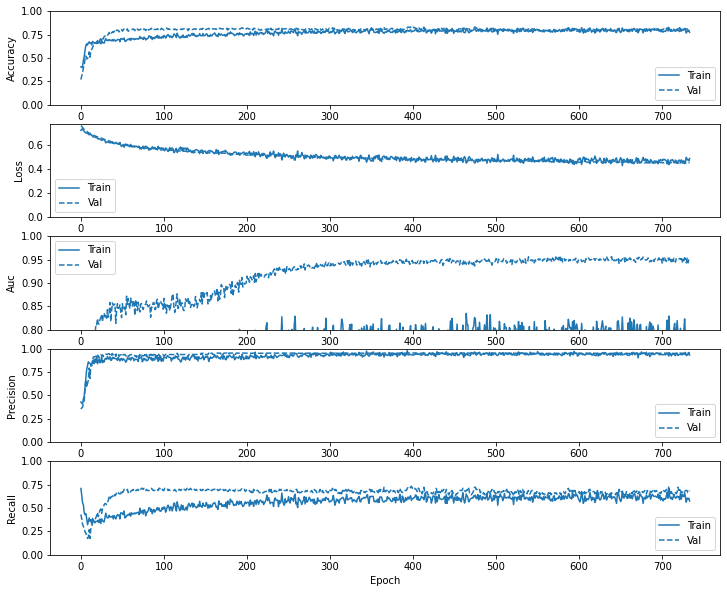

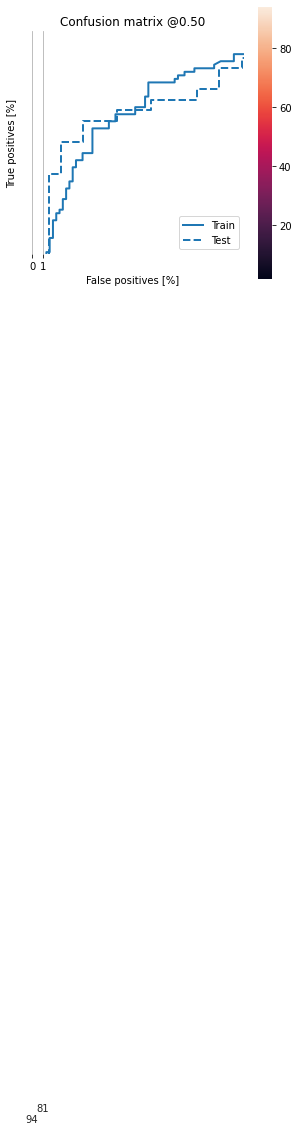

In [19]:
%%time
expId = 101
desc = str(expId) + " AngleEmbedding BasicEntanglerLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits)) 
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_101, history_101 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 426s 33s/step - loss: 0.9543 - tp: 247.2143 - fp: 192.5000 - tn: 94.0000 - fn: 35.1429 - accuracy: 0.6223 - precision: 0.5891 - recall: 0.8677 - auc: 0.6819 - val_loss: 0.8379 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.6582
Epoch 2/10000
13/13 [==============================] - 427s 33s/step - loss: 0.9456 - tp: 164.9286 - fp: 191.9286 - tn: 0.0000e+00 - fn: 13.0000 - accuracy: 0.4389 - precision: 0.4543 - recall: 0.9279 - auc: 0.4763 - val_loss: 0.8217 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.6853
Epoch 3/10000
13/13 [==============================] - 425s 33s/step - loss: 0.9514 - tp: 158.8571 - fp: 193.4286 - tn: 0.3571 - fn: 17.2143 - accuracy: 0.4193 - precision: 0.4390 - recall: 0.9023 - auc: 0.4

Epoch 22/10000
13/13 [==============================] - 426s 33s/step - loss: 0.6800 - tp: 174.0714 - fp: 184.8571 - tn: 2.7143 - fn: 8.2143 - accuracy: 0.4840 - precision: 0.4919 - recall: 0.9517 - auc: 0.6420 - val_loss: 0.6292 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.8226
Epoch 23/10000
13/13 [==============================] - 425s 33s/step - loss: 0.6722 - tp: 174.6429 - fp: 187.6429 - tn: 0.7857 - fn: 6.7857 - accuracy: 0.4793 - precision: 0.4872 - recall: 0.9646 - auc: 0.6455 - val_loss: 0.6244 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.8208
Epoch 24/10000
13/13 [==============================] - 425s 33s/step - loss: 0.6787 - tp: 165.6429 - fp: 193.7143 - tn: 0.0000e+00 - fn: 10.5000 - accuracy: 0.4509 - precision: 0.4656 - recall: 0.9348 - auc: 0.6

Epoch 43/10000
13/13 [==============================] - 425s 33s/step - loss: 0.6012 - tp: 62.2857 - fp: 3.9286 - tn: 187.8571 - fn: 115.7857 - accuracy: 0.6813 - precision: 0.9368 - recall: 0.3596 - auc: 0.6955 - val_loss: 0.5638 - val_tp: 63.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 23.0000 - val_accuracy: 0.7987 - val_precision: 0.8750 - val_recall: 0.7326 - val_auc: 0.8032
Epoch 44/10000
13/13 [==============================] - 426s 33s/step - loss: 0.5900 - tp: 75.0000 - fp: 9.0714 - tn: 184.2143 - fn: 101.5714 - accuracy: 0.7172 - precision: 0.8837 - recall: 0.4594 - auc: 0.7161 - val_loss: 0.5592 - val_tp: 63.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 23.0000 - val_accuracy: 0.8050 - val_precision: 0.8873 - val_recall: 0.7326 - val_auc: 0.8346
Epoch 45/10000
13/13 [==============================] - 426s 33s/step - loss: 0.6069 - tp: 69.6429 - fp: 9.6429 - tn: 181.6429 - fn: 108.9286 - accuracy: 0.6755 - precision: 0.8690 - recall: 0.3902 - auc: 0.6711 - val_loss: 

13/13 [==============================] - 429s 33s/step - loss: 0.5323 - tp: 78.5000 - fp: 7.0714 - tn: 186.5714 - fn: 97.7143 - accuracy: 0.7233 - precision: 0.9216 - recall: 0.4513 - auc: 0.7979 - val_loss: 0.5168 - val_tp: 64.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 22.0000 - val_accuracy: 0.8113 - val_precision: 0.8889 - val_recall: 0.7442 - val_auc: 0.8903
Epoch 86/10000
13/13 [==============================] - 429s 33s/step - loss: 0.5349 - tp: 83.9286 - fp: 7.5714 - tn: 178.3571 - fn: 100.0000 - accuracy: 0.7086 - precision: 0.9262 - recall: 0.4579 - auc: 0.8241 - val_loss: 0.5113 - val_tp: 64.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 22.0000 - val_accuracy: 0.8113 - val_precision: 0.8889 - val_recall: 0.7442 - val_auc: 0.8903
Epoch 87/10000
13/13 [==============================] - 430s 33s/step - loss: 0.5559 - tp: 67.0714 - fp: 5.0714 - tn: 184.5714 - fn: 113.1429 - accuracy: 0.6837 - precision: 0.9270 - recall: 0.3833 - auc: 0.7679 - val_loss: 0.5127 - val_tp:

13/13 [==============================] - 431s 33s/step - loss: 0.4910 - tp: 85.5000 - fp: 15.1429 - tn: 171.5714 - fn: 97.6429 - accuracy: 0.6943 - precision: 0.8542 - recall: 0.4780 - auc: 0.8082 - val_loss: 0.4448 - val_tp: 74.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 12.0000 - val_accuracy: 0.8679 - val_precision: 0.8916 - val_recall: 0.8605 - val_auc: 0.9279
Epoch 128/10000
13/13 [==============================] - 431s 33s/step - loss: 0.4996 - tp: 83.4286 - fp: 15.0714 - tn: 175.2143 - fn: 96.1429 - accuracy: 0.6850 - precision: 0.8337 - recall: 0.4511 - auc: 0.8148 - val_loss: 0.4484 - val_tp: 73.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 13.0000 - val_accuracy: 0.8742 - val_precision: 0.9125 - val_recall: 0.8488 - val_auc: 0.9218
Epoch 129/10000
13/13 [==============================] - 430s 33s/step - loss: 0.5173 - tp: 84.5000 - fp: 16.8571 - tn: 167.6429 - fn: 100.8571 - accuracy: 0.6809 - precision: 0.8594 - recall: 0.4570 - auc: 0.7742 - val_loss: 0.4435 - val

13/13 [==============================] - 430s 33s/step - loss: 0.4768 - tp: 90.7857 - fp: 19.5000 - tn: 171.5000 - fn: 88.0714 - accuracy: 0.7099 - precision: 0.8377 - recall: 0.5063 - auc: 0.8182 - val_loss: 0.4218 - val_tp: 74.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 12.0000 - val_accuracy: 0.8805 - val_precision: 0.9136 - val_recall: 0.8605 - val_auc: 0.9397
Epoch 170/10000
13/13 [==============================] - 431s 33s/step - loss: 0.4994 - tp: 82.5714 - fp: 18.2857 - tn: 176.0714 - fn: 92.9286 - accuracy: 0.6993 - precision: 0.8123 - recall: 0.4625 - auc: 0.7975 - val_loss: 0.4261 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9397
Epoch 171/10000
13/13 [==============================] - 430s 33s/step - loss: 0.4892 - tp: 81.3571 - fp: 13.8571 - tn: 180.6429 - fn: 94.0000 - accuracy: 0.7147 - precision: 0.8483 - recall: 0.4836 - auc: 0.8126 - val_loss: 0.4229 - val_

13/13 [==============================] - 430s 33s/step - loss: 0.4641 - tp: 104.7143 - fp: 35.6429 - tn: 155.5000 - fn: 74.0000 - accuracy: 0.7067 - precision: 0.7491 - recall: 0.5904 - auc: 0.8403 - val_loss: 0.4104 - val_tp: 75.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 11.0000 - val_accuracy: 0.8868 - val_precision: 0.9146 - val_recall: 0.8721 - val_auc: 0.9435
Epoch 212/10000
13/13 [==============================] - 429s 33s/step - loss: 0.4778 - tp: 94.3571 - fp: 34.5714 - tn: 158.8571 - fn: 82.0714 - accuracy: 0.6892 - precision: 0.7462 - recall: 0.5372 - auc: 0.8130 - val_loss: 0.4108 - val_tp: 76.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 10.0000 - val_accuracy: 0.8931 - val_precision: 0.9157 - val_recall: 0.8837 - val_auc: 0.9418
Epoch 213/10000
13/13 [==============================] - 430s 33s/step - loss: 0.4909 - tp: 92.5714 - fp: 31.0000 - tn: 160.2857 - fn: 86.0000 - accuracy: 0.6816 - precision: 0.7391 - recall: 0.5160 - auc: 0.7960 - val_loss: 0.4124 - val

13/13 [==============================] - 429s 33s/step - loss: 0.4774 - tp: 87.2857 - fp: 20.7857 - tn: 173.0000 - fn: 88.7857 - accuracy: 0.7041 - precision: 0.8037 - recall: 0.4882 - auc: 0.8132 - val_loss: 0.3961 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9488
Epoch 254/10000
13/13 [==============================] - 432s 33s/step - loss: 0.4356 - tp: 97.0714 - fp: 28.8571 - tn: 161.0714 - fn: 82.8571 - accuracy: 0.6904 - precision: 0.7543 - recall: 0.5121 - auc: 0.8219 - val_loss: 0.4003 - val_tp: 76.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 10.0000 - val_accuracy: 0.8994 - val_precision: 0.9268 - val_recall: 0.8837 - val_auc: 0.9440
Epoch 255/10000
13/13 [==============================] - 429s 33s/step - loss: 0.4918 - tp: 90.2143 - fp: 24.7143 - tn: 164.8571 - fn: 90.0714 - accuracy: 0.6870 - precision: 0.7721 - recall: 0.5070 - auc: 0.7838 - val_loss: 0.4031 - val_

13/13 [==============================] - 431s 33s/step - loss: 0.4702 - tp: 89.4286 - fp: 25.7857 - tn: 163.3571 - fn: 91.2857 - accuracy: 0.6767 - precision: 0.7548 - recall: 0.4985 - auc: 0.8008 - val_loss: 0.3933 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9493
Epoch 296/10000
13/13 [==============================] - 431s 33s/step - loss: 0.4510 - tp: 108.2857 - fp: 32.7857 - tn: 158.5000 - fn: 70.2857 - accuracy: 0.7204 - precision: 0.7576 - recall: 0.6285 - auc: 0.8207 - val_loss: 0.3949 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9501
Epoch 297/10000
13/13 [==============================] - 430s 33s/step - loss: 0.4876 - tp: 89.5714 - fp: 21.0714 - tn: 171.5000 - fn: 87.7143 - accuracy: 0.7040 - precision: 0.8229 - recall: 0.4952 - auc: 0.8240 - val_loss: 0.3941 - val

13/13 [==============================] - 431s 33s/step - loss: 0.4785 - tp: 87.0714 - fp: 27.2857 - tn: 172.6429 - fn: 82.8571 - accuracy: 0.7014 - precision: 0.7429 - recall: 0.5234 - auc: 0.8124 - val_loss: 0.3894 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9456
Epoch 338/10000
13/13 [==============================] - 429s 33s/step - loss: 0.4931 - tp: 96.3571 - fp: 32.8571 - tn: 163.5714 - fn: 77.0714 - accuracy: 0.6977 - precision: 0.7249 - recall: 0.5505 - auc: 0.8028 - val_loss: 0.3897 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9461
Epoch 339/10000
13/13 [==============================] - 430s 33s/step - loss: 0.4457 - tp: 101.8571 - fp: 34.5714 - tn: 154.0714 - fn: 79.3571 - accuracy: 0.6884 - precision: 0.7630 - recall: 0.5529 - auc: 0.8343 - val_loss: 0.3861 - val

13/13 [==============================] - 430s 33s/step - loss: 0.4536 - tp: 95.9286 - fp: 31.9286 - tn: 160.2143 - fn: 81.7857 - accuracy: 0.6946 - precision: 0.7572 - recall: 0.5463 - auc: 0.8265 - val_loss: 0.3882 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9517
Epoch 380/10000
13/13 [==============================] - 432s 33s/step - loss: 0.4493 - tp: 97.5000 - fp: 31.0000 - tn: 163.5714 - fn: 77.7857 - accuracy: 0.7080 - precision: 0.7538 - recall: 0.5645 - auc: 0.8248 - val_loss: 0.3888 - val_tp: 77.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 9.0000 - val_accuracy: 0.9119 - val_precision: 0.9390 - val_recall: 0.8953 - val_auc: 0.9500
Epoch 381/10000
13/13 [==============================] - 431s 33s/step - loss: 0.4632 - tp: 114.2857 - fp: 36.2143 - tn: 157.9286 - fn: 61.4286 - accuracy: 0.7473 - precision: 0.7813 - recall: 0.6574 - auc: 0.8347 - val_loss: 0.3869 - val_

13/13 [==============================] - 430s 33s/step - loss: 0.4297 - tp: 99.9286 - fp: 24.3571 - tn: 170.5000 - fn: 75.0714 - accuracy: 0.7367 - precision: 0.7988 - recall: 0.5801 - auc: 0.8423 - val_loss: 0.3770 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9538
Epoch 422/10000
13/13 [==============================] - 431s 33s/step - loss: 0.4652 - tp: 99.4286 - fp: 22.4286 - tn: 169.5714 - fn: 78.4286 - accuracy: 0.7226 - precision: 0.8080 - recall: 0.5389 - auc: 0.8280 - val_loss: 0.3805 - val_tp: 76.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 10.0000 - val_accuracy: 0.8994 - val_precision: 0.9268 - val_recall: 0.8837 - val_auc: 0.9508
Epoch 423/10000
13/13 [==============================] - 430s 33s/step - loss: 0.5053 - tp: 95.4286 - fp: 33.2857 - tn: 150.3571 - fn: 90.7857 - accuracy: 0.6479 - precision: 0.7354 - recall: 0.5051 - auc: 0.7677 - val_loss: 0.3842 - val_

13/13 [==============================] - 430s 33s/step - loss: 0.4747 - tp: 94.6429 - fp: 37.5000 - tn: 154.7857 - fn: 82.9286 - accuracy: 0.6847 - precision: 0.7343 - recall: 0.5410 - auc: 0.8036 - val_loss: 0.3846 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9490
Epoch 464/10000
13/13 [==============================] - 430s 33s/step - loss: 0.4837 - tp: 108.7143 - fp: 39.5000 - tn: 149.0714 - fn: 72.5714 - accuracy: 0.6912 - precision: 0.7269 - recall: 0.5932 - auc: 0.7885 - val_loss: 0.3832 - val_tp: 77.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 9.0000 - val_accuracy: 0.9119 - val_precision: 0.9390 - val_recall: 0.8953 - val_auc: 0.9510
Epoch 465/10000
13/13 [==============================] - 431s 33s/step - loss: 0.4442 - tp: 108.8571 - fp: 28.4286 - tn: 165.1429 - fn: 67.4286 - accuracy: 0.7372 - precision: 0.7764 - recall: 0.6158 - auc: 0.8297 - val_loss: 0.3861 - val

13/13 [==============================] - 411s 32s/step - loss: 0.4797 - tp: 106.5000 - fp: 36.6429 - tn: 147.0000 - fn: 79.7143 - accuracy: 0.6743 - precision: 0.7479 - recall: 0.5678 - auc: 0.7896 - val_loss: 0.3804 - val_tp: 74.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 12.0000 - val_accuracy: 0.8931 - val_precision: 0.9367 - val_recall: 0.8605 - val_auc: 0.9477
Epoch 506/10000
13/13 [==============================] - 411s 32s/step - loss: 0.4881 - tp: 97.5000 - fp: 24.7857 - tn: 165.5000 - fn: 82.0714 - accuracy: 0.7090 - precision: 0.7834 - recall: 0.5302 - auc: 0.8072 - val_loss: 0.3795 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9507
Epoch 507/10000
13/13 [==============================] - 410s 32s/step - loss: 0.4681 - tp: 90.9286 - fp: 20.9286 - tn: 172.5714 - fn: 85.4286 - accuracy: 0.7119 - precision: 0.8006 - recall: 0.5104 - auc: 0.8095 - val_loss: 0.3766 - val

13/13 [==============================] - 412s 32s/step - loss: 0.4386 - tp: 115.0714 - fp: 41.7143 - tn: 148.7857 - fn: 64.2857 - accuracy: 0.7195 - precision: 0.7438 - recall: 0.6530 - auc: 0.8508 - val_loss: 0.3749 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9479
Epoch 548/10000
13/13 [==============================] - 412s 32s/step - loss: 0.4505 - tp: 114.5000 - fp: 47.7857 - tn: 146.5000 - fn: 61.0714 - accuracy: 0.7077 - precision: 0.6999 - recall: 0.6654 - auc: 0.8258 - val_loss: 0.3702 - val_tp: 76.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 10.0000 - val_accuracy: 0.8994 - val_precision: 0.9268 - val_recall: 0.8837 - val_auc: 0.9514
Epoch 549/10000
13/13 [==============================] - 411s 32s/step - loss: 0.4551 - tp: 120.0714 - fp: 37.2857 - tn: 150.5000 - fn: 62.0000 - accuracy: 0.7380 - precision: 0.7752 - recall: 0.6579 - auc: 0.8401 - val_loss: 0.3696 - v

13/13 [==============================] - 413s 32s/step - loss: 0.4454 - tp: 102.4286 - fp: 19.2143 - tn: 175.5714 - fn: 72.6429 - accuracy: 0.7581 - precision: 0.8380 - recall: 0.5879 - auc: 0.8378 - val_loss: 0.3731 - val_tp: 76.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 10.0000 - val_accuracy: 0.8994 - val_precision: 0.9268 - val_recall: 0.8837 - val_auc: 0.9511
Epoch 590/10000
13/13 [==============================] - 411s 32s/step - loss: 0.4610 - tp: 103.3571 - fp: 27.7143 - tn: 158.7143 - fn: 80.0714 - accuracy: 0.7024 - precision: 0.7877 - recall: 0.5501 - auc: 0.8227 - val_loss: 0.3735 - val_tp: 75.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 11.0000 - val_accuracy: 0.8931 - val_precision: 0.9259 - val_recall: 0.8721 - val_auc: 0.9528
Epoch 591/10000
13/13 [==============================] - 412s 32s/step - loss: 0.4450 - tp: 98.0714 - fp: 24.0714 - tn: 170.5000 - fn: 77.2143 - accuracy: 0.7291 - precision: 0.8135 - recall: 0.5575 - auc: 0.8268 - val_loss: 0.3701 - va

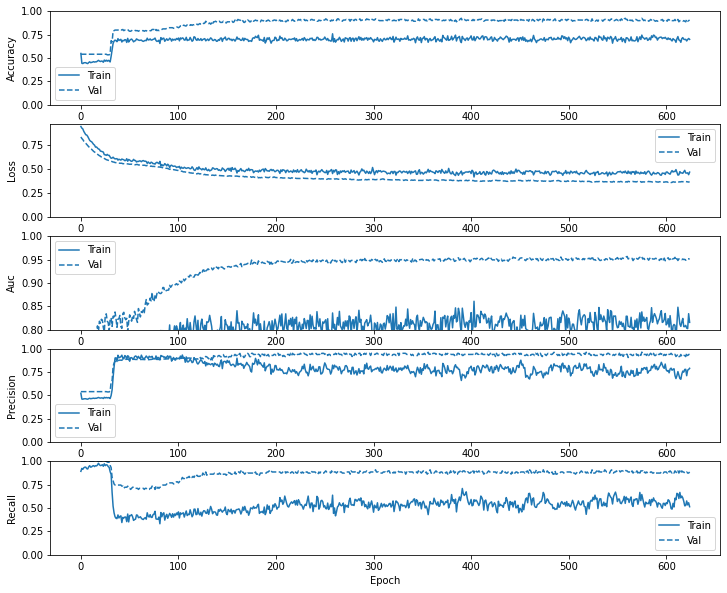

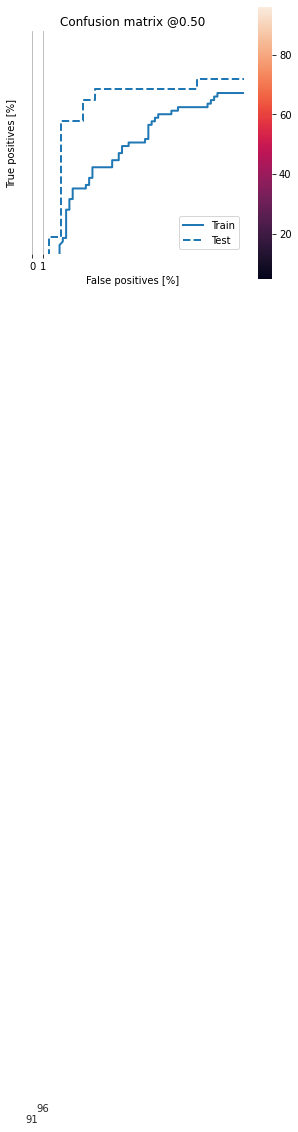

In [20]:
%%time
expId = 102
desc = str(expId) + " AngleEmbedding RandomLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.RandomLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_102, history_102 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 862s 66s/step - loss: 0.6880 - tp: 232.8571 - fp: 188.6429 - tn: 97.8571 - fn: 49.5000 - accuracy: 0.6126 - precision: 0.5820 - recall: 0.8379 - auc: 0.7524 - val_loss: 0.6718 - val_tp: 81.0000 - val_fp: 71.0000 - val_tn: 2.0000 - val_fn: 5.0000 - val_accuracy: 0.5220 - val_precision: 0.5329 - val_recall: 0.9419 - val_auc: 0.6300
Epoch 2/10000
13/13 [==============================] - 863s 66s/step - loss: 0.6826 - tp: 123.4286 - fp: 181.7857 - tn: 10.1429 - fn: 54.5000 - accuracy: 0.3604 - precision: 0.4021 - recall: 0.7238 - auc: 0.4560 - val_loss: 0.6654 - val_tp: 74.0000 - val_fp: 53.0000 - val_tn: 20.0000 - val_fn: 12.0000 - val_accuracy: 0.5912 - val_precision: 0.5827 - val_recall: 0.8605 - val_auc: 0.7362
Epoch 3/10000
13/13 [==============================] - 865s 67s/step - loss: 0.6689 - tp: 93.3571 - fp: 108.2143 - tn: 85.5714 - fn: 82.7143 - accuracy: 0.4765 - precision: 0.4536 - recall: 0.5800 - auc: 0.5147 - val_loss: 0

13/13 [==============================] - 865s 67s/step - loss: 0.6009 - tp: 66.4286 - fp: 6.6429 - tn: 185.1429 - fn: 111.6429 - accuracy: 0.6796 - precision: 0.9185 - recall: 0.3650 - auc: 0.7474 - val_loss: 0.5751 - val_tp: 46.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 40.0000 - val_accuracy: 0.7233 - val_precision: 0.9200 - val_recall: 0.5349 - val_auc: 0.8460
Epoch 44/10000
13/13 [==============================] - 863s 66s/step - loss: 0.5978 - tp: 68.3571 - fp: 5.7857 - tn: 187.5000 - fn: 108.2143 - accuracy: 0.6979 - precision: 0.9047 - recall: 0.3960 - auc: 0.7547 - val_loss: 0.5764 - val_tp: 46.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 40.0000 - val_accuracy: 0.7233 - val_precision: 0.9200 - val_recall: 0.5349 - val_auc: 0.8354
Epoch 45/10000
13/13 [==============================] - 866s 67s/step - loss: 0.5884 - tp: 75.7857 - fp: 5.7143 - tn: 185.5714 - fn: 102.7857 - accuracy: 0.6965 - precision: 0.9183 - recall: 0.4112 - auc: 0.7412 - val_loss: 0.5709 - val_tp

13/13 [==============================] - 869s 67s/step - loss: 0.5761 - tp: 76.2143 - fp: 7.7143 - tn: 185.9286 - fn: 100.0000 - accuracy: 0.7061 - precision: 0.9105 - recall: 0.4154 - auc: 0.7156 - val_loss: 0.5468 - val_tp: 54.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 32.0000 - val_accuracy: 0.7736 - val_precision: 0.9310 - val_recall: 0.6279 - val_auc: 0.8899
Epoch 86/10000
13/13 [==============================] - 866s 67s/step - loss: 0.5614 - tp: 87.3571 - fp: 7.7143 - tn: 178.2143 - fn: 96.5714 - accuracy: 0.7117 - precision: 0.9138 - recall: 0.4725 - auc: 0.7157 - val_loss: 0.5448 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.8930
Epoch 87/10000
13/13 [==============================] - 867s 67s/step - loss: 0.5574 - tp: 79.0714 - fp: 9.8571 - tn: 179.7857 - fn: 101.1429 - accuracy: 0.7105 - precision: 0.8896 - recall: 0.4664 - auc: 0.7416 - val_loss: 0.5437 - val_tp:

13/13 [==============================] - 868s 67s/step - loss: 0.5557 - tp: 87.0000 - fp: 9.6429 - tn: 177.0714 - fn: 96.1429 - accuracy: 0.7186 - precision: 0.9096 - recall: 0.4926 - auc: 0.7287 - val_loss: 0.5311 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.9126
Epoch 128/10000
13/13 [==============================] - 865s 67s/step - loss: 0.5590 - tp: 83.2143 - fp: 8.3571 - tn: 181.9286 - fn: 96.3571 - accuracy: 0.7117 - precision: 0.9100 - recall: 0.4601 - auc: 0.7354 - val_loss: 0.5303 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.9194
Epoch 129/10000
13/13 [==============================] - 865s 67s/step - loss: 0.5715 - tp: 82.0000 - fp: 8.0714 - tn: 176.4286 - fn: 103.3571 - accuracy: 0.6972 - precision: 0.9308 - recall: 0.4452 - auc: 0.7425 - val_loss: 0.5276 - val_tp

13/13 [==============================] - 863s 66s/step - loss: 0.5484 - tp: 87.1429 - fp: 6.2857 - tn: 184.7143 - fn: 91.7143 - accuracy: 0.7284 - precision: 0.9466 - recall: 0.4743 - auc: 0.7395 - val_loss: 0.5171 - val_tp: 57.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 29.0000 - val_accuracy: 0.7925 - val_precision: 0.9344 - val_recall: 0.6628 - val_auc: 0.9140
Epoch 170/10000
13/13 [==============================] - 866s 67s/step - loss: 0.5424 - tp: 86.9286 - fp: 8.2857 - tn: 186.0714 - fn: 88.5714 - accuracy: 0.7371 - precision: 0.8966 - recall: 0.4944 - auc: 0.7290 - val_loss: 0.5129 - val_tp: 57.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 29.0000 - val_accuracy: 0.7925 - val_precision: 0.9344 - val_recall: 0.6628 - val_auc: 0.9236
Epoch 171/10000
13/13 [==============================] - 865s 67s/step - loss: 0.5283 - tp: 85.5714 - fp: 6.6429 - tn: 187.8571 - fn: 89.7857 - accuracy: 0.7446 - precision: 0.9297 - recall: 0.4974 - auc: 0.7759 - val_loss: 0.5140 - val_tp:

13/13 [==============================] - 866s 67s/step - loss: 0.5278 - tp: 91.2857 - fp: 2.7857 - tn: 188.3571 - fn: 87.4286 - accuracy: 0.7514 - precision: 0.9734 - recall: 0.4989 - auc: 0.7364 - val_loss: 0.5027 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.9189
Epoch 212/10000
13/13 [==============================] - 868s 67s/step - loss: 0.5593 - tp: 82.1429 - fp: 11.0000 - tn: 182.4286 - fn: 94.2857 - accuracy: 0.7122 - precision: 0.8804 - recall: 0.4639 - auc: 0.7317 - val_loss: 0.5057 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.9075
Epoch 213/10000
13/13 [==============================] - 865s 67s/step - loss: 0.5448 - tp: 88.7143 - fp: 8.4286 - tn: 182.8571 - fn: 89.8571 - accuracy: 0.7276 - precision: 0.9011 - recall: 0.4813 - auc: 0.7322 - val_loss: 0.5031 - val_tp

13/13 [==============================] - 866s 67s/step - loss: 0.5102 - tp: 94.1429 - fp: 5.7143 - tn: 188.0714 - fn: 81.9286 - accuracy: 0.7676 - precision: 0.9349 - recall: 0.5440 - auc: 0.7752 - val_loss: 0.5087 - val_tp: 62.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 24.0000 - val_accuracy: 0.8239 - val_precision: 0.9394 - val_recall: 0.7209 - val_auc: 0.9152
Epoch 254/10000
13/13 [==============================] - 866s 67s/step - loss: 0.5002 - tp: 97.3571 - fp: 7.5714 - tn: 182.3571 - fn: 82.5714 - accuracy: 0.7594 - precision: 0.9223 - recall: 0.5424 - auc: 0.7807 - val_loss: 0.5061 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.9274
Epoch 255/10000
13/13 [==============================] - 865s 67s/step - loss: 0.5110 - tp: 92.5000 - fp: 4.1429 - tn: 185.4286 - fn: 87.7857 - accuracy: 0.7554 - precision: 0.9679 - recall: 0.5119 - auc: 0.7904 - val_loss: 0.5065 - val_tp:

13/13 [==============================] - 865s 67s/step - loss: 0.5003 - tp: 103.1429 - fp: 8.7143 - tn: 180.4286 - fn: 77.5714 - accuracy: 0.7689 - precision: 0.9195 - recall: 0.5744 - auc: 0.8305 - val_loss: 0.5263 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9252
Epoch 296/10000
13/13 [==============================] - 865s 67s/step - loss: 0.5265 - tp: 104.2857 - fp: 9.3571 - tn: 181.9286 - fn: 74.2857 - accuracy: 0.7656 - precision: 0.9051 - recall: 0.5788 - auc: 0.7831 - val_loss: 0.5288 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9259
Epoch 297/10000
13/13 [==============================] - 865s 67s/step - loss: 0.4960 - tp: 101.0714 - fp: 5.8571 - tn: 186.7143 - fn: 76.2143 - accuracy: 0.7750 - precision: 0.9446 - recall: 0.5672 - auc: 0.7960 - val_loss: 0.5249 - val_

13/13 [==============================] - 865s 67s/step - loss: 0.5158 - tp: 92.5000 - fp: 8.2143 - tn: 191.7143 - fn: 77.4286 - accuracy: 0.7629 - precision: 0.9048 - recall: 0.5312 - auc: 0.7637 - val_loss: 0.5246 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9411
Epoch 338/10000
13/13 [==============================] - 863s 66s/step - loss: 0.5214 - tp: 90.5000 - fp: 7.3571 - tn: 189.0714 - fn: 82.9286 - accuracy: 0.7633 - precision: 0.9322 - recall: 0.5236 - auc: 0.7627 - val_loss: 0.5234 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9362
Epoch 339/10000
13/13 [==============================] - 865s 66s/step - loss: 0.5016 - tp: 107.1429 - fp: 7.2857 - tn: 181.3571 - fn: 74.0714 - accuracy: 0.7710 - precision: 0.9433 - recall: 0.5808 - auc: 0.7973 - val_loss: 0.5236 - val_tp

13/13 [==============================] - 864s 66s/step - loss: 0.4909 - tp: 104.8571 - fp: 4.3571 - tn: 187.7857 - fn: 72.8571 - accuracy: 0.7898 - precision: 0.9618 - recall: 0.5911 - auc: 0.7707 - val_loss: 0.5173 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9397
Epoch 380/10000
13/13 [==============================] - 865s 67s/step - loss: 0.5105 - tp: 95.6429 - fp: 7.6429 - tn: 186.9286 - fn: 79.6429 - accuracy: 0.7618 - precision: 0.9128 - recall: 0.5463 - auc: 0.7906 - val_loss: 0.5182 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9407
Epoch 381/10000
13/13 [==============================] - 866s 67s/step - loss: 0.4652 - tp: 109.0000 - fp: 5.2857 - tn: 188.8571 - fn: 66.7143 - accuracy: 0.8053 - precision: 0.9519 - recall: 0.6250 - auc: 0.8133 - val_loss: 0.5175 - val_t

13/13 [==============================] - 862s 66s/step - loss: 0.4753 - tp: 104.5714 - fp: 3.7143 - tn: 191.1429 - fn: 70.4286 - accuracy: 0.8063 - precision: 0.9655 - recall: 0.6058 - auc: 0.7924 - val_loss: 0.5134 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9399
Epoch 422/10000
13/13 [==============================] - 863s 66s/step - loss: 0.4930 - tp: 109.3571 - fp: 8.5714 - tn: 183.4286 - fn: 68.5000 - accuracy: 0.7849 - precision: 0.9061 - recall: 0.6066 - auc: 0.7798 - val_loss: 0.5095 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9426
Epoch 423/10000
13/13 [==============================] - 865s 67s/step - loss: 0.5389 - tp: 101.5000 - fp: 6.9286 - tn: 176.7143 - fn: 84.7143 - accuracy: 0.7378 - precision: 0.9287 - recall: 0.5374 - auc: 0.7745 - val_loss: 0.5119 - val_

13/13 [==============================] - 863s 66s/step - loss: 0.4899 - tp: 96.8571 - fp: 4.2143 - tn: 188.0714 - fn: 80.7143 - accuracy: 0.7772 - precision: 0.9644 - recall: 0.5573 - auc: 0.7716 - val_loss: 0.4987 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9452
Epoch 464/10000
13/13 [==============================] - 862s 66s/step - loss: 0.4876 - tp: 103.6429 - fp: 6.7857 - tn: 181.7857 - fn: 77.6429 - accuracy: 0.7764 - precision: 0.9439 - recall: 0.5790 - auc: 0.7862 - val_loss: 0.4989 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9423
Epoch 465/10000
13/13 [==============================] - 863s 66s/step - loss: 0.4468 - tp: 115.6429 - fp: 6.8571 - tn: 186.7143 - fn: 60.6429 - accuracy: 0.8239 - precision: 0.9459 - recall: 0.6623 - auc: 0.8454 - val_loss: 0.4989 - val_t

13/13 [==============================] - 866s 67s/step - loss: 0.5015 - tp: 109.2857 - fp: 5.3571 - tn: 178.2857 - fn: 76.9286 - accuracy: 0.7602 - precision: 0.9485 - recall: 0.5725 - auc: 0.7918 - val_loss: 0.5017 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9416
Epoch 506/10000
13/13 [==============================] - 864s 66s/step - loss: 0.4770 - tp: 109.0714 - fp: 4.5000 - tn: 185.7857 - fn: 70.5000 - accuracy: 0.7933 - precision: 0.9554 - recall: 0.5884 - auc: 0.8038 - val_loss: 0.4966 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9442
Epoch 507/10000
13/13 [==============================] - 865s 67s/step - loss: 0.4827 - tp: 104.7857 - fp: 7.0000 - tn: 186.5000 - fn: 71.5714 - accuracy: 0.7863 - precision: 0.9333 - recall: 0.5845 - auc: 0.7942 - val_loss: 0.4967 - val_

13/13 [==============================] - 864s 66s/step - loss: 0.4675 - tp: 115.3571 - fp: 9.0000 - tn: 181.5000 - fn: 64.0000 - accuracy: 0.8002 - precision: 0.9274 - recall: 0.6440 - auc: 0.8077 - val_loss: 0.4942 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9362
Epoch 548/10000
13/13 [==============================] - 865s 67s/step - loss: 0.4531 - tp: 108.3571 - fp: 6.6429 - tn: 187.6429 - fn: 67.2143 - accuracy: 0.8125 - precision: 0.9460 - recall: 0.6390 - auc: 0.8170 - val_loss: 0.4954 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9417
Epoch 549/10000
13/13 [==============================] - 865s 67s/step - loss: 0.4958 - tp: 107.0714 - fp: 7.1429 - tn: 180.6429 - fn: 75.0000 - accuracy: 0.7705 - precision: 0.9353 - recall: 0.5691 - auc: 0.7665 - val_loss: 0.4936 - val_

13/13 [==============================] - 864s 66s/step - loss: 0.4616 - tp: 110.0000 - fp: 3.8571 - tn: 190.9286 - fn: 65.0714 - accuracy: 0.8150 - precision: 0.9745 - recall: 0.6125 - auc: 0.8015 - val_loss: 0.4848 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9380
Epoch 590/10000
13/13 [==============================] - 866s 67s/step - loss: 0.4895 - tp: 109.7143 - fp: 8.2143 - tn: 178.2143 - fn: 73.7143 - accuracy: 0.7874 - precision: 0.9375 - recall: 0.6137 - auc: 0.7800 - val_loss: 0.4834 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9450
Epoch 591/10000
13/13 [==============================] - 867s 67s/step - loss: 0.4445 - tp: 108.7143 - fp: 3.3571 - tn: 191.2143 - fn: 66.5714 - accuracy: 0.8169 - precision: 0.9789 - recall: 0.6267 - auc: 0.8093 - val_loss: 0.4818 - val_

13/13 [==============================] - 864s 66s/step - loss: 0.5056 - tp: 101.3571 - fp: 5.9286 - tn: 186.3571 - fn: 76.2143 - accuracy: 0.7724 - precision: 0.9418 - recall: 0.5538 - auc: 0.7534 - val_loss: 0.4810 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9469
Epoch 632/10000
13/13 [==============================] - 866s 67s/step - loss: 0.4734 - tp: 103.6429 - fp: 4.4286 - tn: 189.2857 - fn: 72.5000 - accuracy: 0.7961 - precision: 0.9617 - recall: 0.5900 - auc: 0.7854 - val_loss: 0.4780 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9430
Epoch 633/10000
13/13 [==============================] - 864s 66s/step - loss: 0.4378 - tp: 119.2143 - fp: 5.8571 - tn: 184.2857 - fn: 60.5000 - accuracy: 0.8234 - precision: 0.9587 - recall: 0.6738 - auc: 0.8329 - val_loss: 0.4838 - val_

13/13 [==============================] - 864s 67s/step - loss: 0.5032 - tp: 105.5714 - fp: 5.6429 - tn: 178.6429 - fn: 80.0000 - accuracy: 0.7613 - precision: 0.9539 - recall: 0.5664 - auc: 0.7732 - val_loss: 0.4771 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9480
Epoch 674/10000
13/13 [==============================] - 866s 67s/step - loss: 0.4403 - tp: 113.4286 - fp: 6.2857 - tn: 187.7857 - fn: 62.3571 - accuracy: 0.8192 - precision: 0.9545 - recall: 0.6437 - auc: 0.8118 - val_loss: 0.4809 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9448
Epoch 675/10000
13/13 [==============================] - 864s 67s/step - loss: 0.4412 - tp: 110.9286 - fp: 5.9286 - tn: 193.0714 - fn: 59.9286 - accuracy: 0.8319 - precision: 0.9484 - recall: 0.6639 - auc: 0.8239 - val_loss: 0.4799 - val_

13/13 [==============================] - 862s 66s/step - loss: 0.4304 - tp: 117.2857 - fp: 7.0714 - tn: 184.0000 - fn: 61.5000 - accuracy: 0.8216 - precision: 0.9517 - recall: 0.6670 - auc: 0.8321 - val_loss: 0.4760 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9468
Epoch 716/10000
13/13 [==============================] - 864s 66s/step - loss: 0.4503 - tp: 113.5000 - fp: 10.5000 - tn: 179.5000 - fn: 66.3571 - accuracy: 0.7934 - precision: 0.9117 - recall: 0.6390 - auc: 0.8059 - val_loss: 0.4731 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9462
Epoch 717/10000
13/13 [==============================] - 862s 66s/step - loss: 0.4838 - tp: 104.0714 - fp: 8.9286 - tn: 186.3571 - fn: 70.5000 - accuracy: 0.7814 - precision: 0.9266 - recall: 0.5872 - auc: 0.7442 - val_loss: 0.4790 - val

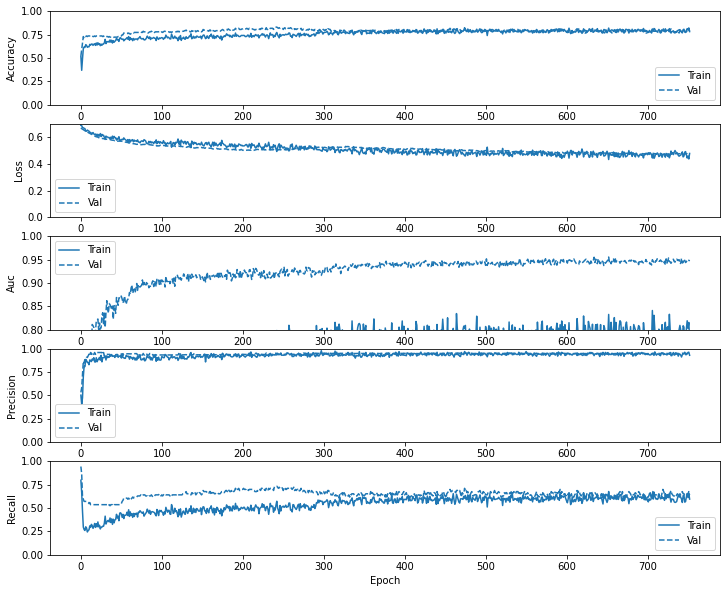

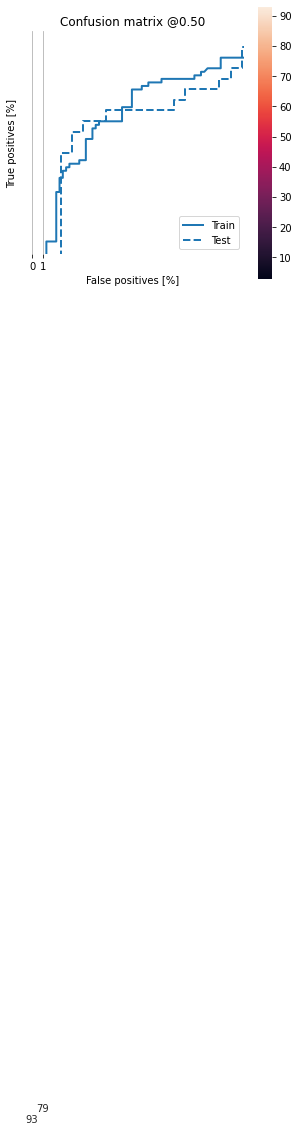

In [21]:
%%time
expId = 103
desc = str(expId) + " AngleEmbedding StronglyEntanglingLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))   
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, {"weights": (n_layers, n_qubits, 3)}, output_dim=n_qubits)

model_103, history_103 = runTheExperiments(expId, desc)

## IQPEmbedding

Epoch 1/10000
13/13 [==============================] - 531s 41s/step - loss: 0.7047 - tp: 170.6429 - fp: 111.0714 - tn: 175.4286 - fn: 111.7143 - accuracy: 0.6305 - precision: 0.6348 - recall: 0.6187 - auc: 0.7289 - val_loss: 0.7165 - val_tp: 38.0000 - val_fp: 48.0000 - val_tn: 25.0000 - val_fn: 48.0000 - val_accuracy: 0.3962 - val_precision: 0.4419 - val_recall: 0.4419 - val_auc: 0.3505
Epoch 2/10000
13/13 [==============================] - 533s 41s/step - loss: 0.7089 - tp: 92.0714 - fp: 107.7857 - tn: 84.1429 - fn: 85.8571 - accuracy: 0.4769 - precision: 0.4552 - recall: 0.5333 - auc: 0.4945 - val_loss: 0.7176 - val_tp: 40.0000 - val_fp: 40.0000 - val_tn: 33.0000 - val_fn: 46.0000 - val_accuracy: 0.4591 - val_precision: 0.5000 - val_recall: 0.4651 - val_auc: 0.3961
Epoch 3/10000
13/13 [==============================] - 531s 41s/step - loss: 0.7189 - tp: 82.7857 - fp: 108.9286 - tn: 84.8571 - fn: 93.2857 - accuracy: 0.4557 - precision: 0.4238 - recall: 0.4803 - auc: 0.4329 - val_loss

13/13 [==============================] - 533s 41s/step - loss: 0.6753 - tp: 51.5000 - fp: 12.2857 - tn: 179.5000 - fn: 126.5714 - accuracy: 0.6258 - precision: 0.8253 - recall: 0.2810 - auc: 0.5945 - val_loss: 0.7949 - val_tp: 1.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 85.0000 - val_accuracy: 0.4465 - val_precision: 0.2500 - val_recall: 0.0116 - val_auc: 0.1795
Epoch 44/10000
13/13 [==============================] - 535s 41s/step - loss: 0.6827 - tp: 37.2857 - fp: 3.5714 - tn: 189.7143 - fn: 139.2857 - accuracy: 0.6201 - precision: 0.9239 - recall: 0.2026 - auc: 0.5279 - val_loss: 0.7965 - val_tp: 0.0000e+00 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 86.0000 - val_accuracy: 0.4277 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1533
Epoch 45/10000
13/13 [==============================] - 534s 41s/step - loss: 0.6825 - tp: 41.9286 - fp: 7.8571 - tn: 183.4286 - fn: 136.6429 - accuracy: 0.6010 - precision: 0.8263 - recall: 0.2234 - auc: 0.5814 - val_loss: 0.79

Epoch 64/10000
13/13 [==============================] - 535s 41s/step - loss: 0.6714 - tp: 47.4286 - fp: 7.3571 - tn: 184.2857 - fn: 130.7857 - accuracy: 0.6136 - precision: 0.8722 - recall: 0.2431 - auc: 0.5720 - val_loss: 0.8018 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 73.0000 - val_fn: 86.0000 - val_accuracy: 0.4591 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1890
Epoch 65/10000
13/13 [==============================] - 534s 41s/step - loss: 0.6717 - tp: 43.8571 - fp: 5.0000 - tn: 186.5714 - fn: 134.4286 - accuracy: 0.6221 - precision: 0.8947 - recall: 0.2419 - auc: 0.5270 - val_loss: 0.8019 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 73.0000 - val_fn: 86.0000 - val_accuracy: 0.4591 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1895
Epoch 66/10000
13/13 [==============================] - 536s 41s/step - loss: 0.6735 - tp: 42.7143 - fp: 5.2857 - tn: 187.3571 - fn: 134.5000 - accuracy: 0.6275 - precision: 0.8825 - recall: 0.2

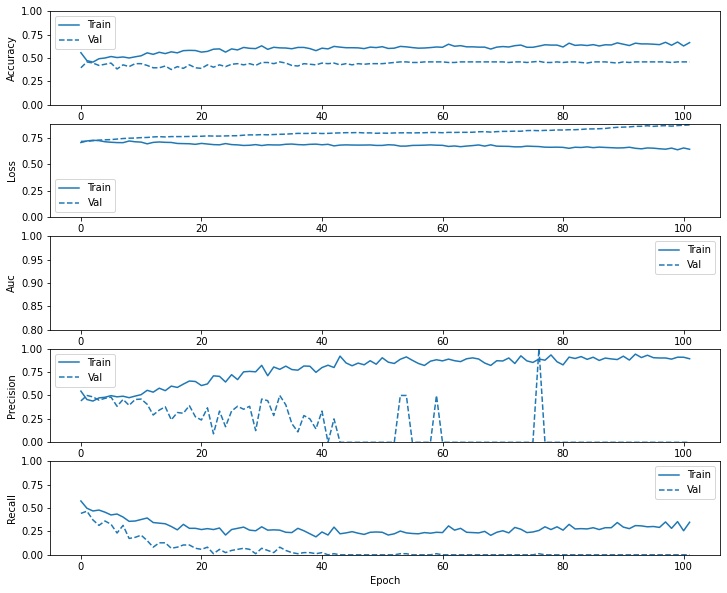

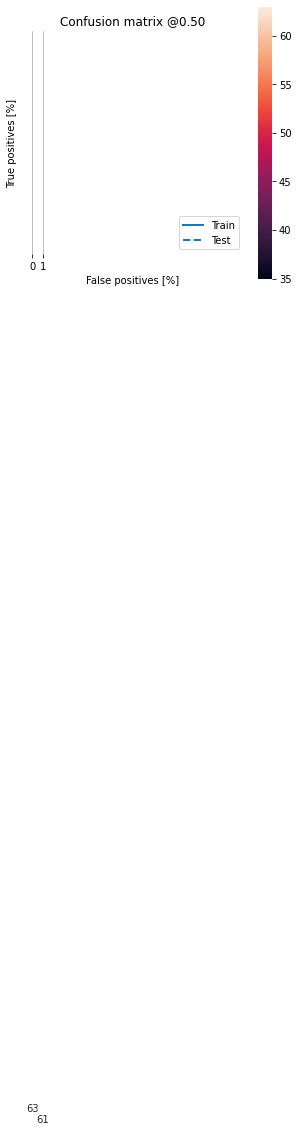

In [22]:
%%time
expId = 104
desc = str(expId) + " IQPEmbedding BasicEntanglerLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_104, history_104 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 512s 39s/step - loss: 0.7394 - tp: 123.7857 - fp: 154.9286 - tn: 131.5714 - fn: 158.5714 - accuracy: 0.4487 - precision: 0.4455 - recall: 0.4431 - auc: 0.4025 - val_loss: 0.7727 - val_tp: 14.0000 - val_fp: 30.0000 - val_tn: 43.0000 - val_fn: 72.0000 - val_accuracy: 0.3585 - val_precision: 0.3182 - val_recall: 0.1628 - val_auc: 0.2389
Epoch 2/10000
13/13 [==============================] - 509s 39s/step - loss: 0.7351 - tp: 77.6429 - fp: 94.5000 - tn: 97.4286 - fn: 100.2857 - accuracy: 0.4751 - precision: 0.4436 - recall: 0.4353 - auc: 0.4387 - val_loss: 0.7661 - val_tp: 17.0000 - val_fp: 29.0000 - val_tn: 44.0000 - val_fn: 69.0000 - val_accuracy: 0.3836 - val_precision: 0.3696 - val_recall: 0.1977 - val_auc: 0.2635
Epoch 3/10000
13/13 [==============================] - 511s 39s/step - loss: 0.7199 - tp: 88.7143 - fp: 108.7857 - tn: 85.0000 - fn: 87.3571 - accuracy: 0.4730 - precision: 0.4420 - recall: 0.5152 - auc: 0.4402 - val_loss

13/13 [==============================] - 511s 39s/step - loss: 0.6832 - tp: 47.7857 - fp: 54.4286 - tn: 137.3571 - fn: 130.2857 - accuracy: 0.5138 - precision: 0.4854 - recall: 0.2771 - auc: 0.5611 - val_loss: 0.6835 - val_tp: 25.0000 - val_fp: 18.0000 - val_tn: 55.0000 - val_fn: 61.0000 - val_accuracy: 0.5031 - val_precision: 0.5814 - val_recall: 0.2907 - val_auc: 0.6009
Epoch 44/10000
13/13 [==============================] - 510s 39s/step - loss: 0.6857 - tp: 58.5714 - fp: 58.5714 - tn: 134.7143 - fn: 118.0000 - accuracy: 0.5267 - precision: 0.4867 - recall: 0.3258 - auc: 0.5184 - val_loss: 0.6862 - val_tp: 22.0000 - val_fp: 13.0000 - val_tn: 60.0000 - val_fn: 64.0000 - val_accuracy: 0.5157 - val_precision: 0.6286 - val_recall: 0.2558 - val_auc: 0.5761
Epoch 45/10000
13/13 [==============================] - 514s 40s/step - loss: 0.6833 - tp: 54.3571 - fp: 49.0000 - tn: 142.2857 - fn: 124.2143 - accuracy: 0.5270 - precision: 0.5193 - recall: 0.2975 - auc: 0.5472 - val_loss: 0.6845 - v

13/13 [==============================] - 513s 40s/step - loss: 0.6240 - tp: 149.5714 - fp: 99.2857 - tn: 94.3571 - fn: 26.6429 - accuracy: 0.6523 - precision: 0.5906 - recall: 0.8553 - auc: 0.6983 - val_loss: 0.5883 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9372
Epoch 86/10000
13/13 [==============================] - 513s 40s/step - loss: 0.6037 - tp: 160.6429 - fp: 86.9286 - tn: 99.0000 - fn: 23.2857 - accuracy: 0.7109 - precision: 0.6600 - recall: 0.8790 - auc: 0.7342 - val_loss: 0.5911 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9196
Epoch 87/10000
13/13 [==============================] - 512s 39s/step - loss: 0.6100 - tp: 153.8571 - fp: 87.4286 - tn: 102.2143 - fn: 26.3571 - accuracy: 0.6934 - precision: 0.6406 - recall: 0.8495 - auc: 0.7140 - val_loss: 0.5856 - val_t

13/13 [==============================] - 514s 40s/step - loss: 0.5885 - tp: 170.2857 - fp: 95.1429 - tn: 91.5714 - fn: 12.8571 - accuracy: 0.7116 - precision: 0.6500 - recall: 0.9349 - auc: 0.7048 - val_loss: 0.5381 - val_tp: 73.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 13.0000 - val_accuracy: 0.8931 - val_precision: 0.9481 - val_recall: 0.8488 - val_auc: 0.9486
Epoch 128/10000
13/13 [==============================] - 513s 40s/step - loss: 0.5900 - tp: 162.0714 - fp: 98.4286 - tn: 91.8571 - fn: 17.5000 - accuracy: 0.6896 - precision: 0.6281 - recall: 0.9055 - auc: 0.6939 - val_loss: 0.5383 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9380
Epoch 129/10000
13/13 [==============================] - 511s 39s/step - loss: 0.5816 - tp: 172.3571 - fp: 92.3571 - tn: 92.1429 - fn: 13.0000 - accuracy: 0.7180 - precision: 0.6601 - recall: 0.9321 - auc: 0.7124 - val_loss: 0.5381 - val_

13/13 [==============================] - 513s 39s/step - loss: 0.5693 - tp: 165.5714 - fp: 95.0714 - tn: 95.9286 - fn: 13.2857 - accuracy: 0.7119 - precision: 0.6421 - recall: 0.9308 - auc: 0.7126 - val_loss: 0.5022 - val_tp: 75.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 11.0000 - val_accuracy: 0.9119 - val_precision: 0.9615 - val_recall: 0.8721 - val_auc: 0.9419
Epoch 170/10000
13/13 [==============================] - 512s 39s/step - loss: 0.5817 - tp: 161.5714 - fp: 100.6429 - tn: 93.7143 - fn: 13.9286 - accuracy: 0.6892 - precision: 0.6117 - recall: 0.9143 - auc: 0.7259 - val_loss: 0.5085 - val_tp: 74.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 12.0000 - val_accuracy: 0.8931 - val_precision: 0.9367 - val_recall: 0.8605 - val_auc: 0.9471
Epoch 171/10000
13/13 [==============================] - 511s 39s/step - loss: 0.5680 - tp: 164.0000 - fp: 100.1429 - tn: 94.3571 - fn: 11.3571 - accuracy: 0.6990 - precision: 0.6196 - recall: 0.9412 - auc: 0.7051 - val_loss: 0.5042 - va

13/13 [==============================] - 511s 39s/step - loss: 0.5836 - tp: 163.1429 - fp: 104.0714 - tn: 87.0714 - fn: 15.5714 - accuracy: 0.6697 - precision: 0.6045 - recall: 0.9154 - auc: 0.7073 - val_loss: 0.4910 - val_tp: 75.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 11.0000 - val_accuracy: 0.9119 - val_precision: 0.9615 - val_recall: 0.8721 - val_auc: 0.9380
Epoch 212/10000
13/13 [==============================] - 510s 39s/step - loss: 0.5752 - tp: 163.9286 - fp: 103.5714 - tn: 89.8571 - fn: 12.5000 - accuracy: 0.6757 - precision: 0.6068 - recall: 0.9221 - auc: 0.7210 - val_loss: 0.4839 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9579
Epoch 213/10000
13/13 [==============================] - 509s 39s/step - loss: 0.5635 - tp: 171.0000 - fp: 104.5714 - tn: 86.7143 - fn: 7.5714 - accuracy: 0.6953 - precision: 0.6164 - recall: 0.9606 - auc: 0.7400 - val_loss: 0.4875 - va

13/13 [==============================] - 512s 39s/step - loss: 0.5821 - tp: 161.5000 - fp: 106.6429 - tn: 87.1429 - fn: 14.5714 - accuracy: 0.6662 - precision: 0.5928 - recall: 0.9221 - auc: 0.6686 - val_loss: 0.4797 - val_tp: 76.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 10.0000 - val_accuracy: 0.8931 - val_precision: 0.9157 - val_recall: 0.8837 - val_auc: 0.9450
Epoch 254/10000
13/13 [==============================] - 514s 40s/step - loss: 0.5440 - tp: 166.9286 - fp: 92.6429 - tn: 97.2857 - fn: 13.0000 - accuracy: 0.7138 - precision: 0.6361 - recall: 0.9395 - auc: 0.7439 - val_loss: 0.4817 - val_tp: 77.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 9.0000 - val_accuracy: 0.9057 - val_precision: 0.9277 - val_recall: 0.8953 - val_auc: 0.9384
Epoch 255/10000
13/13 [==============================] - 512s 39s/step - loss: 0.5769 - tp: 163.6429 - fp: 99.7857 - tn: 89.7857 - fn: 16.6429 - accuracy: 0.6865 - precision: 0.6208 - recall: 0.9080 - auc: 0.7074 - val_loss: 0.4759 - val_

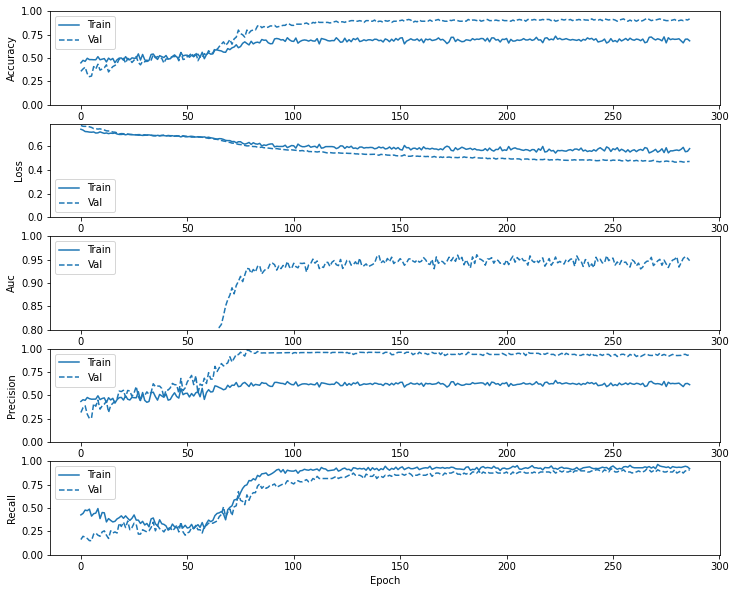

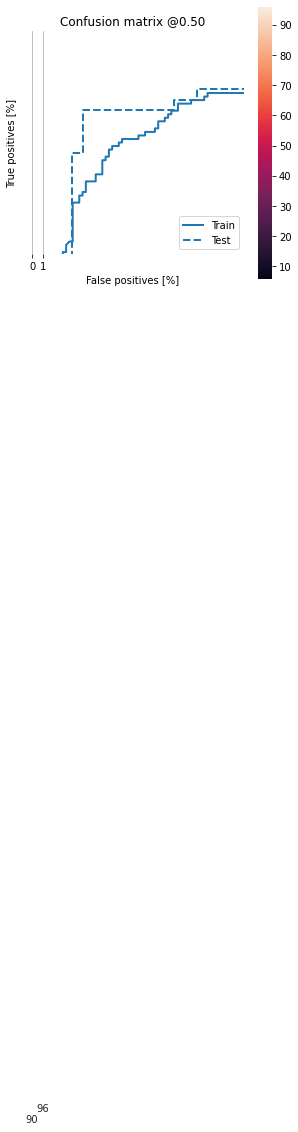

In [23]:
%%time
expId = 105
desc = str(expId) + " IQPEmbedding RandomLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.RandomLayers(weights, wires=range(n_qubits))   
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_105, history_105 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 846s 65s/step - loss: 0.7276 - tp: 160.3571 - fp: 185.4286 - tn: 5.0714 - fn: 19.0000 - accuracy: 0.4471 - precision: 0.4610 - recall: 0.8963 - auc: 0.4627 - val_loss: 0.7253 - val_tp: 69.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 17.0000 - val_accuracy: 0.4340 - val_precision: 0.4859 - val_recall: 0.8023 - val_auc: 0.3313
Epoch 2/10000
13/13 [==============================] - 929s 71s/step - loss: 0.7328 - tp: 153.4286 - fp: 191.4286 - tn: 0.5000 - fn: 24.5000 - accuracy: 0.4121 - precision: 0.4388 - recall: 0.8699 - auc: 0.4362 - val_loss: 0.7220 - val_tp: 66.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 20.0000 - val_accuracy: 0.4151 - val_precision: 0.4748 - val_recall: 0.7674 - val_auc: 0.3215
Epoch 3/10000
13/13 [==============================] - 925s 71s/step - loss: 0.7402 - tp: 148.7857 - fp: 193.3571 - tn: 0.4286 - fn: 27.2857 - accuracy: 0.3945 - precision: 0.4241 - recall: 0.8488 - auc: 0.3779 - val_l

13/13 [==============================] - 925s 71s/step - loss: 0.6985 - tp: 90.8571 - fp: 80.7143 - tn: 106.8571 - fn: 91.4286 - accuracy: 0.5390 - precision: 0.5417 - recall: 0.5061 - auc: 0.5105 - val_loss: 0.7106 - val_tp: 23.0000 - val_fp: 28.0000 - val_tn: 45.0000 - val_fn: 63.0000 - val_accuracy: 0.4277 - val_precision: 0.4510 - val_recall: 0.2674 - val_auc: 0.3444
Epoch 23/10000
13/13 [==============================] - 927s 71s/step - loss: 0.6906 - tp: 85.9286 - fp: 72.5714 - tn: 115.8571 - fn: 95.5000 - accuracy: 0.5617 - precision: 0.5599 - recall: 0.5112 - auc: 0.5823 - val_loss: 0.7098 - val_tp: 24.0000 - val_fp: 30.0000 - val_tn: 43.0000 - val_fn: 62.0000 - val_accuracy: 0.4214 - val_precision: 0.4444 - val_recall: 0.2791 - val_auc: 0.3414
Epoch 24/10000
13/13 [==============================] - 925s 71s/step - loss: 0.6971 - tp: 68.8571 - fp: 67.0000 - tn: 126.7143 - fn: 107.2857 - accuracy: 0.5348 - precision: 0.5206 - recall: 0.4099 - auc: 0.5125 - val_loss: 0.7113 - val

13/13 [==============================] - 928s 71s/step - loss: 0.6837 - tp: 48.6429 - fp: 3.5714 - tn: 188.2143 - fn: 129.4286 - accuracy: 0.6506 - precision: 0.9228 - recall: 0.2965 - auc: 0.6097 - val_loss: 0.7115 - val_tp: 13.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 73.0000 - val_accuracy: 0.5157 - val_precision: 0.7647 - val_recall: 0.1512 - val_auc: 0.3197
Epoch 44/10000
13/13 [==============================] - 926s 71s/step - loss: 0.6843 - tp: 49.7143 - fp: 8.0000 - tn: 185.2857 - fn: 126.8571 - accuracy: 0.6624 - precision: 0.8682 - recall: 0.3301 - auc: 0.5949 - val_loss: 0.7145 - val_tp: 12.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 74.0000 - val_accuracy: 0.5031 - val_precision: 0.7059 - val_recall: 0.1395 - val_auc: 0.3080
Epoch 45/10000
13/13 [==============================] - 929s 71s/step - loss: 0.6942 - tp: 40.0714 - fp: 5.4286 - tn: 185.8571 - fn: 138.5000 - accuracy: 0.6062 - precision: 0.8660 - recall: 0.2232 - auc: 0.5307 - val_loss: 0.7119 - val_tp

13/13 [==============================] - 928s 71s/step - loss: 0.6865 - tp: 43.5000 - fp: 4.5000 - tn: 187.1429 - fn: 134.7143 - accuracy: 0.6283 - precision: 0.9109 - recall: 0.2593 - auc: 0.5682 - val_loss: 0.7130 - val_tp: 13.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 73.0000 - val_accuracy: 0.5220 - val_precision: 0.8125 - val_recall: 0.1512 - val_auc: 0.3715
Epoch 65/10000
13/13 [==============================] - 926s 71s/step - loss: 0.6876 - tp: 43.0714 - fp: 5.0000 - tn: 186.5714 - fn: 135.2143 - accuracy: 0.6196 - precision: 0.8862 - recall: 0.2396 - auc: 0.5385 - val_loss: 0.7134 - val_tp: 13.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 73.0000 - val_accuracy: 0.5220 - val_precision: 0.8125 - val_recall: 0.1512 - val_auc: 0.3394
Epoch 66/10000
13/13 [==============================] - 928s 71s/step - loss: 0.6848 - tp: 44.9286 - fp: 6.2143 - tn: 186.4286 - fn: 132.2857 - accuracy: 0.6320 - precision: 0.8847 - recall: 0.2597 - auc: 0.5529 - val_loss: 0.7157 - val_tp

13/13 [==============================] - 921s 71s/step - loss: 0.6563 - tp: 57.5000 - fp: 2.0000 - tn: 191.6429 - fn: 118.7143 - accuracy: 0.6818 - precision: 0.9737 - recall: 0.3334 - auc: 0.6594 - val_loss: 0.7243 - val_tp: 15.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 71.0000 - val_accuracy: 0.5346 - val_precision: 0.8333 - val_recall: 0.1744 - val_auc: 0.3454
Epoch 86/10000
13/13 [==============================] - 925s 71s/step - loss: 0.6626 - tp: 59.8571 - fp: 3.5714 - tn: 182.3571 - fn: 124.0714 - accuracy: 0.6536 - precision: 0.9589 - recall: 0.3261 - auc: 0.6212 - val_loss: 0.7278 - val_tp: 15.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 71.0000 - val_accuracy: 0.5283 - val_precision: 0.7895 - val_recall: 0.1744 - val_auc: 0.3210
Epoch 87/10000
13/13 [==============================] - 926s 71s/step - loss: 0.6710 - tp: 44.9286 - fp: 3.5000 - tn: 186.1429 - fn: 135.2857 - accuracy: 0.6202 - precision: 0.9140 - recall: 0.2436 - auc: 0.5801 - val_loss: 0.7264 - val_tp

13/13 [==============================] - 924s 71s/step - loss: 0.6302 - tp: 65.5714 - fp: 4.2143 - tn: 183.6429 - fn: 116.4286 - accuracy: 0.6761 - precision: 0.9407 - recall: 0.3764 - auc: 0.6688 - val_loss: 0.7699 - val_tp: 15.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 71.0000 - val_accuracy: 0.5346 - val_precision: 0.8333 - val_recall: 0.1744 - val_auc: 0.3686
Epoch 107/10000
13/13 [==============================] - 922s 71s/step - loss: 0.6257 - tp: 59.5714 - fp: 3.1429 - tn: 185.8571 - fn: 121.2857 - accuracy: 0.6716 - precision: 0.9571 - recall: 0.3405 - auc: 0.6666 - val_loss: 0.7705 - val_tp: 18.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 68.0000 - val_accuracy: 0.5535 - val_precision: 0.8571 - val_recall: 0.2093 - val_auc: 0.3485
Epoch 108/10000
13/13 [==============================] - 922s 71s/step - loss: 0.6268 - tp: 61.2143 - fp: 5.5714 - tn: 184.0000 - fn: 119.0714 - accuracy: 0.6729 - precision: 0.9201 - recall: 0.3550 - auc: 0.6895 - val_loss: 0.7705 - val_

13/13 [==============================] - 923s 71s/step - loss: 0.5807 - tp: 71.0714 - fp: 4.4286 - tn: 182.2857 - fn: 112.0714 - accuracy: 0.6858 - precision: 0.9470 - recall: 0.4019 - auc: 0.7454 - val_loss: 0.8158 - val_tp: 14.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 72.0000 - val_accuracy: 0.5283 - val_precision: 0.8235 - val_recall: 0.1628 - val_auc: 0.3754
Epoch 128/10000
13/13 [==============================] - 926s 71s/step - loss: 0.5999 - tp: 66.9286 - fp: 5.6429 - tn: 184.6429 - fn: 112.6429 - accuracy: 0.6704 - precision: 0.9139 - recall: 0.3651 - auc: 0.7273 - val_loss: 0.8191 - val_tp: 15.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 71.0000 - val_accuracy: 0.5346 - val_precision: 0.8333 - val_recall: 0.1744 - val_auc: 0.3685
Epoch 129/10000
13/13 [==============================] - 925s 71s/step - loss: 0.6003 - tp: 65.9286 - fp: 6.4286 - tn: 178.0714 - fn: 119.4286 - accuracy: 0.6499 - precision: 0.9303 - recall: 0.3489 - auc: 0.7333 - val_loss: 0.8211 - val_

13/13 [==============================] - 924s 71s/step - loss: 0.5914 - tp: 66.0000 - fp: 5.3571 - tn: 186.2857 - fn: 112.2143 - accuracy: 0.6708 - precision: 0.9062 - recall: 0.3535 - auc: 0.7254 - val_loss: 0.7683 - val_tp: 18.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 68.0000 - val_accuracy: 0.5535 - val_precision: 0.8571 - val_recall: 0.2093 - val_auc: 0.5101
Epoch 149/10000
13/13 [==============================] - 922s 71s/step - loss: 0.6015 - tp: 67.3571 - fp: 5.8571 - tn: 180.7857 - fn: 115.8571 - accuracy: 0.6623 - precision: 0.9174 - recall: 0.3622 - auc: 0.7062 - val_loss: 0.7741 - val_tp: 19.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 67.0000 - val_accuracy: 0.5597 - val_precision: 0.8636 - val_recall: 0.2209 - val_auc: 0.4964
Epoch 150/10000
13/13 [==============================] - 926s 71s/step - loss: 0.5817 - tp: 59.2857 - fp: 7.1429 - tn: 189.4286 - fn: 114.0000 - accuracy: 0.6765 - precision: 0.9043 - recall: 0.3385 - auc: 0.7203 - val_loss: 0.7716 - val_

13/13 [==============================] - 922s 71s/step - loss: 0.5864 - tp: 76.0000 - fp: 8.0000 - tn: 183.0000 - fn: 102.8571 - accuracy: 0.6952 - precision: 0.9194 - recall: 0.4160 - auc: 0.7370 - val_loss: 0.7090 - val_tp: 21.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 65.0000 - val_accuracy: 0.5723 - val_precision: 0.8750 - val_recall: 0.2442 - val_auc: 0.6622
Epoch 170/10000
13/13 [==============================] - 925s 71s/step - loss: 0.5820 - tp: 69.0000 - fp: 6.7857 - tn: 187.5714 - fn: 106.5000 - accuracy: 0.6905 - precision: 0.9134 - recall: 0.3726 - auc: 0.7712 - val_loss: 0.6998 - val_tp: 20.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 66.0000 - val_accuracy: 0.5660 - val_precision: 0.8696 - val_recall: 0.2326 - val_auc: 0.7133
Epoch 171/10000
13/13 [==============================] - 924s 71s/step - loss: 0.5574 - tp: 74.3571 - fp: 6.1429 - tn: 188.3571 - fn: 101.0000 - accuracy: 0.7196 - precision: 0.9280 - recall: 0.4405 - auc: 0.7856 - val_loss: 0.6988 - val_

13/13 [==============================] - 925s 71s/step - loss: 0.5631 - tp: 78.8571 - fp: 8.0000 - tn: 189.1429 - fn: 93.8571 - accuracy: 0.7209 - precision: 0.9061 - recall: 0.4447 - auc: 0.7780 - val_loss: 0.6410 - val_tp: 36.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 50.0000 - val_accuracy: 0.6667 - val_precision: 0.9231 - val_recall: 0.4186 - val_auc: 0.7958
Epoch 191/10000
13/13 [==============================] - 925s 71s/step - loss: 0.5337 - tp: 91.5000 - fp: 6.7143 - tn: 186.2857 - fn: 85.3571 - accuracy: 0.7596 - precision: 0.9352 - recall: 0.5323 - auc: 0.7980 - val_loss: 0.6354 - val_tp: 40.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 46.0000 - val_accuracy: 0.6918 - val_precision: 0.9302 - val_recall: 0.4651 - val_auc: 0.8064
Epoch 192/10000
13/13 [==============================] - 926s 71s/step - loss: 0.5146 - tp: 96.5714 - fp: 6.2857 - tn: 188.0714 - fn: 78.9286 - accuracy: 0.7734 - precision: 0.9511 - recall: 0.5455 - auc: 0.8234 - val_loss: 0.6309 - val_tp:

13/13 [==============================] - 925s 71s/step - loss: 0.5471 - tp: 96.1429 - fp: 5.5000 - tn: 185.6429 - fn: 82.5714 - accuracy: 0.7536 - precision: 0.9441 - recall: 0.5206 - auc: 0.7556 - val_loss: 0.5831 - val_tp: 51.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 35.0000 - val_accuracy: 0.7610 - val_precision: 0.9444 - val_recall: 0.5930 - val_auc: 0.8783
Epoch 212/10000
13/13 [==============================] - 925s 71s/step - loss: 0.5460 - tp: 94.1429 - fp: 9.7143 - tn: 183.7143 - fn: 82.2857 - accuracy: 0.7538 - precision: 0.9076 - recall: 0.5424 - auc: 0.7814 - val_loss: 0.5860 - val_tp: 49.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 37.0000 - val_accuracy: 0.7484 - val_precision: 0.9423 - val_recall: 0.5698 - val_auc: 0.8633
Epoch 213/10000
13/13 [==============================] - 924s 71s/step - loss: 0.5529 - tp: 98.2143 - fp: 8.7143 - tn: 182.5714 - fn: 80.3571 - accuracy: 0.7523 - precision: 0.9136 - recall: 0.5305 - auc: 0.7627 - val_loss: 0.5821 - val_tp:

13/13 [==============================] - 926s 71s/step - loss: 0.5307 - tp: 96.2857 - fp: 9.7143 - tn: 187.5000 - fn: 76.3571 - accuracy: 0.7764 - precision: 0.9132 - recall: 0.5715 - auc: 0.7504 - val_loss: 0.5502 - val_tp: 52.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 34.0000 - val_accuracy: 0.7673 - val_precision: 0.9455 - val_recall: 0.6047 - val_auc: 0.9034
Epoch 233/10000
13/13 [==============================] - 928s 71s/step - loss: 0.5578 - tp: 88.8571 - fp: 8.5000 - tn: 183.1429 - fn: 89.3571 - accuracy: 0.7390 - precision: 0.9143 - recall: 0.4974 - auc: 0.7489 - val_loss: 0.5462 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9119
Epoch 234/10000
13/13 [==============================] - 937s 72s/step - loss: 0.5236 - tp: 99.4286 - fp: 6.9286 - tn: 186.5714 - fn: 76.9286 - accuracy: 0.7780 - precision: 0.9285 - recall: 0.5645 - auc: 0.7770 - val_loss: 0.5440 - val_tp:

13/13 [==============================] - 927s 71s/step - loss: 0.5146 - tp: 100.1429 - fp: 5.0000 - tn: 188.7857 - fn: 75.9286 - accuracy: 0.7839 - precision: 0.9448 - recall: 0.5741 - auc: 0.7865 - val_loss: 0.5190 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9195
Epoch 254/10000
13/13 [==============================] - 926s 71s/step - loss: 0.4847 - tp: 107.4286 - fp: 5.8571 - tn: 184.0714 - fn: 72.5000 - accuracy: 0.7957 - precision: 0.9548 - recall: 0.6025 - auc: 0.8271 - val_loss: 0.5219 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9229
Epoch 255/10000
13/13 [==============================] - 926s 71s/step - loss: 0.4972 - tp: 108.4286 - fp: 6.2857 - tn: 183.2857 - fn: 71.8571 - accuracy: 0.7943 - precision: 0.9510 - recall: 0.6078 - auc: 0.7874 - val_loss: 0.5199 - val_

13/13 [==============================] - 922s 71s/step - loss: 0.4829 - tp: 101.9286 - fp: 8.4286 - tn: 190.2857 - fn: 69.2143 - accuracy: 0.8052 - precision: 0.9062 - recall: 0.6270 - auc: 0.8061 - val_loss: 0.5055 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9254
Epoch 275/10000
13/13 [==============================] - 926s 71s/step - loss: 0.4909 - tp: 110.2143 - fp: 6.0000 - tn: 185.0714 - fn: 68.5714 - accuracy: 0.8063 - precision: 0.9549 - recall: 0.6302 - auc: 0.8192 - val_loss: 0.5043 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9306
Epoch 276/10000
13/13 [==============================] - 925s 71s/step - loss: 0.5308 - tp: 105.5714 - fp: 5.0714 - tn: 184.1429 - fn: 75.0714 - accuracy: 0.7746 - precision: 0.9537 - recall: 0.5690 - auc: 0.7653 - val_loss: 0.5015 - val_

13/13 [==============================] - 926s 71s/step - loss: 0.4941 - tp: 110.3571 - fp: 10.0000 - tn: 179.1429 - fn: 70.3571 - accuracy: 0.7844 - precision: 0.9068 - recall: 0.6201 - auc: 0.8042 - val_loss: 0.4898 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9360
Epoch 296/10000
13/13 [==============================] - 927s 71s/step - loss: 0.4928 - tp: 110.5000 - fp: 9.2857 - tn: 182.0000 - fn: 68.0714 - accuracy: 0.7870 - precision: 0.9170 - recall: 0.6174 - auc: 0.7934 - val_loss: 0.4999 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9316
Epoch 297/10000
13/13 [==============================] - 925s 71s/step - loss: 0.4906 - tp: 106.4286 - fp: 6.4286 - tn: 186.1429 - fn: 70.8571 - accuracy: 0.7914 - precision: 0.9480 - recall: 0.6007 - auc: 0.8068 - val_loss: 0.4928 - val

13/13 [==============================] - 926s 71s/step - loss: 0.4969 - tp: 110.2857 - fp: 8.3571 - tn: 182.0714 - fn: 69.1429 - accuracy: 0.7751 - precision: 0.9226 - recall: 0.5976 - auc: 0.7931 - val_loss: 0.4816 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9442
Epoch 317/10000
13/13 [==============================] - 926s 71s/step - loss: 0.4669 - tp: 111.7857 - fp: 2.6429 - tn: 191.1429 - fn: 64.2857 - accuracy: 0.8270 - precision: 0.9840 - recall: 0.6417 - auc: 0.8145 - val_loss: 0.4883 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9434
Epoch 318/10000
13/13 [==============================] - 926s 71s/step - loss: 0.4950 - tp: 107.5000 - fp: 6.7143 - tn: 188.0000 - fn: 67.6429 - accuracy: 0.8011 - precision: 0.9507 - recall: 0.6153 - auc: 0.7812 - val_loss: 0.4860 - val_

13/13 [==============================] - 925s 71s/step - loss: 0.5086 - tp: 97.1429 - fp: 9.2143 - tn: 190.7143 - fn: 72.7857 - accuracy: 0.7757 - precision: 0.9059 - recall: 0.5626 - auc: 0.7816 - val_loss: 0.4788 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9435
Epoch 338/10000
13/13 [==============================] - 926s 71s/step - loss: 0.5075 - tp: 97.7143 - fp: 7.8571 - tn: 188.5714 - fn: 75.7143 - accuracy: 0.7789 - precision: 0.9303 - recall: 0.5614 - auc: 0.7750 - val_loss: 0.4808 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9385
Epoch 339/10000
13/13 [==============================] - 926s 71s/step - loss: 0.4978 - tp: 111.8571 - fp: 8.4286 - tn: 180.2143 - fn: 69.3571 - accuracy: 0.7808 - precision: 0.9392 - recall: 0.6054 - auc: 0.7916 - val_loss: 0.4834 - val_tp

13/13 [==============================] - 926s 71s/step - loss: 0.5032 - tp: 101.3571 - fp: 5.5714 - tn: 185.5000 - fn: 77.4286 - accuracy: 0.7803 - precision: 0.9575 - recall: 0.5707 - auc: 0.7584 - val_loss: 0.4746 - val_tp: 61.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 25.0000 - val_accuracy: 0.8176 - val_precision: 0.9385 - val_recall: 0.7093 - val_auc: 0.9505
Epoch 359/10000
13/13 [==============================] - 928s 71s/step - loss: 0.4798 - tp: 110.0000 - fp: 6.7857 - tn: 180.7143 - fn: 72.3571 - accuracy: 0.7847 - precision: 0.9482 - recall: 0.5985 - auc: 0.8075 - val_loss: 0.4750 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9453
Epoch 360/10000
13/13 [==============================] - 926s 71s/step - loss: 0.5275 - tp: 101.8571 - fp: 9.6429 - tn: 179.3571 - fn: 79.0000 - accuracy: 0.7566 - precision: 0.9111 - recall: 0.5573 - auc: 0.7636 - val_loss: 0.4747 - val_

13/13 [==============================] - 928s 71s/step - loss: 0.4821 - tp: 109.0714 - fp: 6.2857 - tn: 185.8571 - fn: 68.6429 - accuracy: 0.7986 - precision: 0.9491 - recall: 0.6186 - auc: 0.7872 - val_loss: 0.4721 - val_tp: 67.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 19.0000 - val_accuracy: 0.8616 - val_precision: 0.9571 - val_recall: 0.7791 - val_auc: 0.9496
Epoch 380/10000
13/13 [==============================] - 927s 71s/step - loss: 0.5073 - tp: 99.4286 - fp: 8.7143 - tn: 185.8571 - fn: 75.8571 - accuracy: 0.7687 - precision: 0.9096 - recall: 0.5642 - auc: 0.7576 - val_loss: 0.4713 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9517
Epoch 381/10000
13/13 [==============================] - 925s 71s/step - loss: 0.4640 - tp: 111.7143 - fp: 4.5714 - tn: 189.5714 - fn: 64.0000 - accuracy: 0.8188 - precision: 0.9647 - recall: 0.6447 - auc: 0.8101 - val_loss: 0.4755 - val_t

13/13 [==============================] - 858s 66s/step - loss: 0.5004 - tp: 106.5000 - fp: 7.6429 - tn: 182.5714 - fn: 73.1429 - accuracy: 0.7705 - precision: 0.9307 - recall: 0.5836 - auc: 0.7754 - val_loss: 0.4634 - val_tp: 68.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 18.0000 - val_accuracy: 0.8679 - val_precision: 0.9577 - val_recall: 0.7907 - val_auc: 0.9415
Epoch 401/10000
13/13 [==============================] - 857s 66s/step - loss: 0.4641 - tp: 107.7143 - fp: 7.7857 - tn: 185.7857 - fn: 68.5714 - accuracy: 0.8000 - precision: 0.9367 - recall: 0.6224 - auc: 0.8057 - val_loss: 0.4652 - val_tp: 66.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 20.0000 - val_accuracy: 0.8553 - val_precision: 0.9565 - val_recall: 0.7674 - val_auc: 0.9418
Epoch 402/10000
13/13 [==============================] - 856s 66s/step - loss: 0.5020 - tp: 106.5714 - fp: 7.3571 - tn: 184.2143 - fn: 71.7143 - accuracy: 0.7755 - precision: 0.9318 - recall: 0.5816 - auc: 0.7836 - val_loss: 0.4565 - val_

13/13 [==============================] - 857s 66s/step - loss: 0.4674 - tp: 107.4286 - fp: 6.7143 - tn: 188.1429 - fn: 67.5714 - accuracy: 0.8042 - precision: 0.9445 - recall: 0.6155 - auc: 0.8113 - val_loss: 0.4592 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9466
Epoch 422/10000
13/13 [==============================] - 857s 66s/step - loss: 0.4852 - tp: 112.0000 - fp: 9.2857 - tn: 182.7143 - fn: 65.8571 - accuracy: 0.7883 - precision: 0.9024 - recall: 0.6171 - auc: 0.8069 - val_loss: 0.4600 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9377
Epoch 423/10000
13/13 [==============================] - 857s 66s/step - loss: 0.5334 - tp: 98.2143 - fp: 7.2143 - tn: 176.4286 - fn: 88.0000 - accuracy: 0.7273 - precision: 0.9252 - recall: 0.5178 - auc: 0.7759 - val_loss: 0.4641 - val_t

13/13 [==============================] - 857s 66s/step - loss: 0.5059 - tp: 101.6429 - fp: 6.5000 - tn: 182.5714 - fn: 79.1429 - accuracy: 0.7664 - precision: 0.9369 - recall: 0.5563 - auc: 0.7694 - val_loss: 0.4567 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9342
Epoch 443/10000
13/13 [==============================] - 857s 66s/step - loss: 0.4764 - tp: 114.5714 - fp: 12.2143 - tn: 179.4286 - fn: 63.6429 - accuracy: 0.7935 - precision: 0.8993 - recall: 0.6500 - auc: 0.8202 - val_loss: 0.4562 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9435
Epoch 444/10000
13/13 [==============================] - 857s 66s/step - loss: 0.4756 - tp: 105.7857 - fp: 10.8571 - tn: 184.7143 - fn: 68.5000 - accuracy: 0.7915 - precision: 0.9024 - recall: 0.6210 - auc: 0.7963 - val_loss: 0.4611 - va

13/13 [==============================] - 858s 66s/step - loss: 0.4852 - tp: 100.1429 - fp: 5.0714 - tn: 187.2143 - fn: 77.4286 - accuracy: 0.7838 - precision: 0.9593 - recall: 0.5747 - auc: 0.7722 - val_loss: 0.4577 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9495
Epoch 464/10000
13/13 [==============================] - 855s 66s/step - loss: 0.4830 - tp: 107.3571 - fp: 8.1429 - tn: 180.4286 - fn: 73.9286 - accuracy: 0.7804 - precision: 0.9300 - recall: 0.5975 - auc: 0.7910 - val_loss: 0.4530 - val_tp: 66.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 20.0000 - val_accuracy: 0.8553 - val_precision: 0.9565 - val_recall: 0.7674 - val_auc: 0.9470
Epoch 465/10000
13/13 [==============================] - 857s 66s/step - loss: 0.4389 - tp: 117.3571 - fp: 6.5000 - tn: 187.0714 - fn: 58.9286 - accuracy: 0.8278 - precision: 0.9482 - recall: 0.6692 - auc: 0.8165 - val_loss: 0.4587 - val_

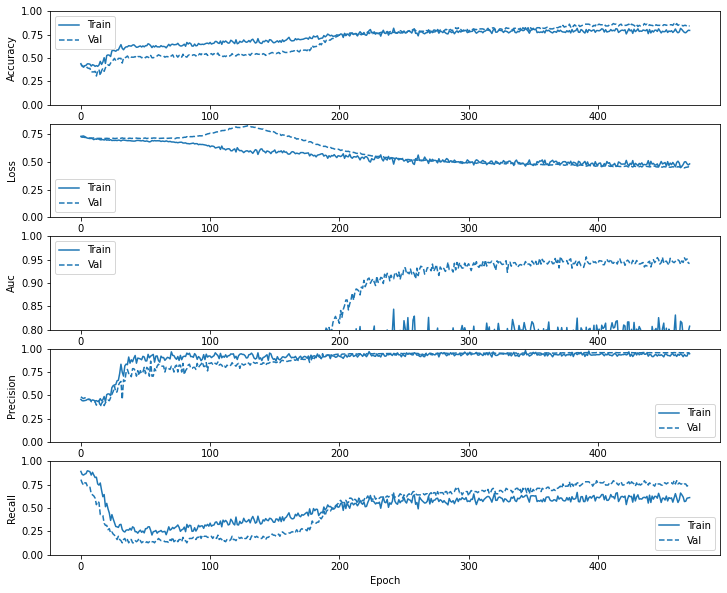

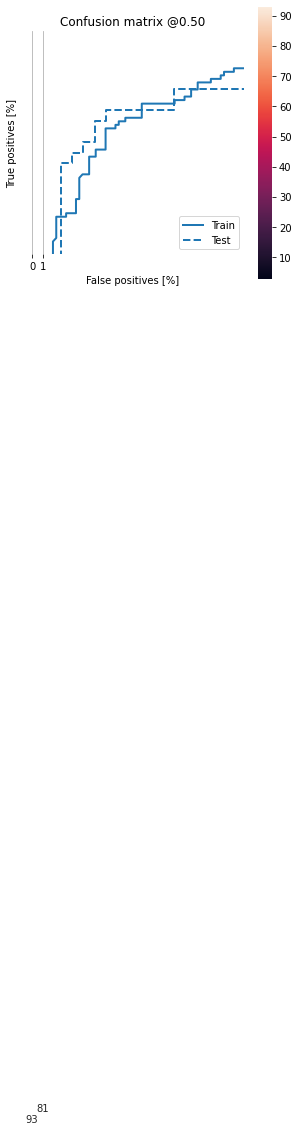

In [35]:
%%time
expId = 106
desc = str(expId) + " IQPEmbedding StronglyEntanglingLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, {"weights": (n_layers, n_qubits, 3)}, output_dim=n_qubits)

model_106, history_106 = runTheExperiments(expId, desc)

# Save Data For Comparisons

In [36]:
#np.savetxt(results_folder + "n" + str(num_data) + "_train_labels.csv", train_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_val_labels.csv", val_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_test_labels.csv", test_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_train_features.csv", train_features, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_val_features.csv", val_features, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_test_features.csv", test_features, delimiter=",")


# Experiments B - Classical Deep Learning

In [37]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          2, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  model.summary()

  return model
  
 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 10        
_________________________________________________________________
dropout_2 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
13/13 [==============================] - 3s 110ms/step - loss: 0.7219 - tp: 135.5000 - fp: 15.0714 - tn: 271.4286 - fn: 146.8571 - accuracy: 0.7289 - precision: 0.9034 - recall: 0.5074 - auc: 0.7253 - val_loss: 0.6798 - val_tp: 34.0000 - val_fp: 11.0000 - val_tn: 62.0000 - val_fn: 52.0000 - val_accuracy: 0.6038 - val_precision: 0.7556 - val_recall: 0.3953 - val_auc: 0.527

13/13 [==============================] - 0s 9ms/step - loss: 0.6285 - tp: 62.1429 - fp: 11.3571 - tn: 178.4286 - fn: 117.9286 - accuracy: 0.6543 - precision: 0.8502 - recall: 0.3342 - auc: 0.6193 - val_loss: 0.5557 - val_tp: 56.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 30.0000 - val_accuracy: 0.7610 - val_precision: 0.8750 - val_recall: 0.6512 - val_auc: 0.8202
Epoch 21/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.6123 - tp: 70.5000 - fp: 9.0000 - tn: 179.2143 - fn: 111.1429 - accuracy: 0.6852 - precision: 0.9026 - recall: 0.4016 - auc: 0.6502 - val_loss: 0.5526 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 30.0000 - val_accuracy: 0.7673 - val_precision: 0.8889 - val_recall: 0.6512 - val_auc: 0.8214
Epoch 22/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.6104 - tp: 71.4286 - fp: 11.5000 - tn: 176.0714 - fn: 110.8571 - accuracy: 0.6622 - precision: 0.8699 - recall: 0.3830 - auc: 0.6580 - val_loss: 0.5500 - val_tp: 56

13/13 [==============================] - 0s 9ms/step - loss: 0.6091 - tp: 59.0714 - fp: 10.9286 - tn: 179.7857 - fn: 120.0714 - accuracy: 0.6333 - precision: 0.8598 - recall: 0.3159 - auc: 0.6379 - val_loss: 0.5134 - val_tp: 59.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 27.0000 - val_accuracy: 0.7925 - val_precision: 0.9077 - val_recall: 0.6860 - val_auc: 0.8596
Epoch 42/10000
13/13 [==============================] - 0s 11ms/step - loss: 0.5634 - tp: 71.0000 - fp: 8.7143 - tn: 188.8571 - fn: 101.2857 - accuracy: 0.7145 - precision: 0.8999 - recall: 0.4204 - auc: 0.7201 - val_loss: 0.5120 - val_tp: 59.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 27.0000 - val_accuracy: 0.7987 - val_precision: 0.9219 - val_recall: 0.6860 - val_auc: 0.8587
Epoch 43/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5910 - tp: 65.7857 - fp: 10.2857 - tn: 181.5000 - fn: 112.2857 - accuracy: 0.6634 - precision: 0.8666 - recall: 0.3504 - auc: 0.6852 - val_loss: 0.5110 - val_tp: 5

13/13 [==============================] - 0s 8ms/step - loss: 0.5836 - tp: 68.2857 - fp: 8.4286 - tn: 180.7143 - fn: 112.4286 - accuracy: 0.6723 - precision: 0.8888 - recall: 0.3720 - auc: 0.6929 - val_loss: 0.4968 - val_tp: 57.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 29.0000 - val_accuracy: 0.7862 - val_precision: 0.9194 - val_recall: 0.6628 - val_auc: 0.8676
Epoch 63/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.6028 - tp: 63.4286 - fp: 13.6429 - tn: 180.8571 - fn: 111.9286 - accuracy: 0.6584 - precision: 0.7919 - recall: 0.3628 - auc: 0.6757 - val_loss: 0.4963 - val_tp: 57.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 29.0000 - val_accuracy: 0.7862 - val_precision: 0.9194 - val_recall: 0.6628 - val_auc: 0.8690
Epoch 64/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.5579 - tp: 74.5000 - fp: 11.3571 - tn: 180.2857 - fn: 103.7143 - accuracy: 0.6857 - precision: 0.8761 - recall: 0.4121 - auc: 0.7283 - val_loss: 0.4953 - val_tp: 57

13/13 [==============================] - 0s 9ms/step - loss: 0.5726 - tp: 72.7857 - fp: 12.3571 - tn: 174.9286 - fn: 109.7857 - accuracy: 0.6662 - precision: 0.8706 - recall: 0.3806 - auc: 0.7171 - val_loss: 0.4787 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 28.0000 - val_accuracy: 0.7925 - val_precision: 0.9206 - val_recall: 0.6744 - val_auc: 0.8773
Epoch 84/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.5872 - tp: 65.1429 - fp: 10.6429 - tn: 182.3571 - fn: 111.7143 - accuracy: 0.6591 - precision: 0.8619 - recall: 0.3479 - auc: 0.6884 - val_loss: 0.4780 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 28.0000 - val_accuracy: 0.7925 - val_precision: 0.9206 - val_recall: 0.6744 - val_auc: 0.8810
Epoch 85/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.5342 - tp: 78.1429 - fp: 7.3571 - tn: 186.2857 - fn: 98.0714 - accuracy: 0.7250 - precision: 0.9222 - recall: 0.4546 - auc: 0.7475 - val_loss: 0.4773 - val_tp: 57

13/13 [==============================] - 0s 8ms/step - loss: 0.5363 - tp: 67.5000 - fp: 5.4286 - tn: 189.4286 - fn: 107.5000 - accuracy: 0.6901 - precision: 0.9313 - recall: 0.3795 - auc: 0.7499 - val_loss: 0.4481 - val_tp: 60.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 26.0000 - val_accuracy: 0.8050 - val_precision: 0.9231 - val_recall: 0.6977 - val_auc: 0.9122
Epoch 105/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5187 - tp: 66.1429 - fp: 6.1429 - tn: 189.4286 - fn: 108.1429 - accuracy: 0.6998 - precision: 0.9219 - recall: 0.3771 - auc: 0.7719 - val_loss: 0.4459 - val_tp: 61.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 25.0000 - val_accuracy: 0.8113 - val_precision: 0.9242 - val_recall: 0.7093 - val_auc: 0.9103
Epoch 106/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5369 - tp: 74.8571 - fp: 11.6429 - tn: 176.2143 - fn: 107.1429 - accuracy: 0.6758 - precision: 0.8678 - recall: 0.4182 - auc: 0.7580 - val_loss: 0.4449 - val_tp: 6

13/13 [==============================] - 0s 9ms/step - loss: 0.5248 - tp: 70.2143 - fp: 8.9286 - tn: 185.2143 - fn: 105.5000 - accuracy: 0.6852 - precision: 0.8623 - recall: 0.3935 - auc: 0.7712 - val_loss: 0.4194 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9307
Epoch 126/10000
13/13 [==============================] - 0s 11ms/step - loss: 0.5285 - tp: 66.3571 - fp: 10.2143 - tn: 183.8571 - fn: 109.4286 - accuracy: 0.6723 - precision: 0.8554 - recall: 0.3661 - auc: 0.7713 - val_loss: 0.4180 - val_tp: 62.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 24.0000 - val_accuracy: 0.8239 - val_precision: 0.9394 - val_recall: 0.7209 - val_auc: 0.9314
Epoch 127/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.5239 - tp: 70.8571 - fp: 6.1429 - tn: 180.5714 - fn: 112.2857 - accuracy: 0.6821 - precision: 0.9373 - recall: 0.3987 - auc: 0.7832 - val_loss: 0.4160 - val_tp: 

13/13 [==============================] - 0s 9ms/step - loss: 0.4946 - tp: 69.8571 - fp: 7.0000 - tn: 180.8571 - fn: 112.1429 - accuracy: 0.6851 - precision: 0.9167 - recall: 0.3964 - auc: 0.7929 - val_loss: 0.3983 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9422
Epoch 147/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.4720 - tp: 85.6429 - fp: 7.2857 - tn: 179.0000 - fn: 97.9286 - accuracy: 0.7163 - precision: 0.9283 - recall: 0.4717 - auc: 0.8224 - val_loss: 0.3976 - val_tp: 66.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 20.0000 - val_accuracy: 0.8553 - val_precision: 0.9565 - val_recall: 0.7674 - val_auc: 0.9423
Epoch 148/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5006 - tp: 71.0714 - fp: 10.1429 - tn: 181.5000 - fn: 107.1429 - accuracy: 0.6886 - precision: 0.8726 - recall: 0.4152 - auc: 0.8039 - val_loss: 0.3971 - val_tp: 6

13/13 [==============================] - 0s 12ms/step - loss: 0.4994 - tp: 69.9286 - fp: 10.2143 - tn: 181.9286 - fn: 107.7857 - accuracy: 0.6837 - precision: 0.8612 - recall: 0.3964 - auc: 0.7840 - val_loss: 0.3848 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9482
Epoch 168/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.4655 - tp: 87.7857 - fp: 5.8571 - tn: 178.3571 - fn: 97.8571 - accuracy: 0.7119 - precision: 0.9442 - recall: 0.4776 - auc: 0.8301 - val_loss: 0.3837 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9483
Epoch 169/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4843 - tp: 73.9286 - fp: 6.2143 - tn: 184.7857 - fn: 104.9286 - accuracy: 0.6951 - precision: 0.9247 - recall: 0.4104 - auc: 0.8039 - val_loss: 0.3836 - val_tp: 

13/13 [==============================] - 0s 9ms/step - loss: 0.4686 - tp: 72.4286 - fp: 4.7143 - tn: 187.5000 - fn: 105.2143 - accuracy: 0.7052 - precision: 0.9441 - recall: 0.4022 - auc: 0.8186 - val_loss: 0.3790 - val_tp: 67.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 19.0000 - val_accuracy: 0.8616 - val_precision: 0.9571 - val_recall: 0.7791 - val_auc: 0.9526
Epoch 189/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4916 - tp: 75.8571 - fp: 10.5000 - tn: 180.1429 - fn: 103.3571 - accuracy: 0.6953 - precision: 0.8758 - recall: 0.4334 - auc: 0.7996 - val_loss: 0.3786 - val_tp: 67.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 19.0000 - val_accuracy: 0.8616 - val_precision: 0.9571 - val_recall: 0.7791 - val_auc: 0.9532
Epoch 190/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4781 - tp: 63.5000 - fp: 7.5000 - tn: 189.6429 - fn: 109.2143 - accuracy: 0.6857 - precision: 0.8891 - recall: 0.3690 - auc: 0.8131 - val_loss: 0.3780 - val_tp: 6

13/13 [==============================] - 0s 9ms/step - loss: 0.4750 - tp: 74.6429 - fp: 6.5714 - tn: 180.7857 - fn: 107.8571 - accuracy: 0.6928 - precision: 0.9176 - recall: 0.4169 - auc: 0.8115 - val_loss: 0.3676 - val_tp: 68.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 18.0000 - val_accuracy: 0.8679 - val_precision: 0.9577 - val_recall: 0.7907 - val_auc: 0.9548
Epoch 210/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.4876 - tp: 70.2857 - fp: 7.0000 - tn: 185.7143 - fn: 106.8571 - accuracy: 0.6914 - precision: 0.9089 - recall: 0.3837 - auc: 0.7934 - val_loss: 0.3673 - val_tp: 68.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 18.0000 - val_accuracy: 0.8679 - val_precision: 0.9577 - val_recall: 0.7907 - val_auc: 0.9541
Epoch 211/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.5002 - tp: 58.2143 - fp: 4.2143 - tn: 186.9286 - fn: 120.5000 - accuracy: 0.6588 - precision: 0.9385 - recall: 0.3151 - auc: 0.7805 - val_loss: 0.3664 - val_tp: 6

13/13 [==============================] - 0s 9ms/step - loss: 0.4552 - tp: 82.9286 - fp: 8.0000 - tn: 181.7857 - fn: 97.1429 - accuracy: 0.7134 - precision: 0.9028 - recall: 0.4610 - auc: 0.8272 - val_loss: 0.3600 - val_tp: 69.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 17.0000 - val_accuracy: 0.8742 - val_precision: 0.9583 - val_recall: 0.8023 - val_auc: 0.9568
Epoch 231/10000
13/13 [==============================] - 0s 12ms/step - loss: 0.4497 - tp: 81.0000 - fp: 6.5000 - tn: 176.8571 - fn: 105.5000 - accuracy: 0.6943 - precision: 0.9288 - recall: 0.4522 - auc: 0.8279 - val_loss: 0.3591 - val_tp: 69.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 17.0000 - val_accuracy: 0.8742 - val_precision: 0.9583 - val_recall: 0.8023 - val_auc: 0.9568
Epoch 232/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.4763 - tp: 70.2143 - fp: 7.2143 - tn: 190.0000 - fn: 102.4286 - accuracy: 0.7101 - precision: 0.9198 - recall: 0.4144 - auc: 0.8093 - val_loss: 0.3577 - val_tp: 6

13/13 [==============================] - 0s 8ms/step - loss: 0.4554 - tp: 82.6429 - fp: 5.4286 - tn: 183.5714 - fn: 98.2143 - accuracy: 0.7192 - precision: 0.9416 - recall: 0.4634 - auc: 0.8269 - val_loss: 0.3507 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9530
Epoch 252/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4639 - tp: 73.4286 - fp: 8.0714 - tn: 188.2857 - fn: 100.0714 - accuracy: 0.7144 - precision: 0.8893 - recall: 0.4311 - auc: 0.8182 - val_loss: 0.3504 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9529
Epoch 253/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4620 - tp: 72.5714 - fp: 5.9286 - tn: 187.8571 - fn: 103.5000 - accuracy: 0.7111 - precision: 0.9255 - recall: 0.4182 - auc: 0.8165 - val_loss: 0.3504 - val_tp: 73.

13/13 [==============================] - 0s 9ms/step - loss: 0.4771 - tp: 82.6429 - fp: 7.4286 - tn: 182.1429 - fn: 97.6429 - accuracy: 0.7091 - precision: 0.9176 - recall: 0.4443 - auc: 0.8156 - val_loss: 0.3440 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9529
Epoch 273/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4725 - tp: 66.2857 - fp: 6.8571 - tn: 189.6429 - fn: 107.0714 - accuracy: 0.6931 - precision: 0.9324 - recall: 0.3728 - auc: 0.8091 - val_loss: 0.3440 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9534
Epoch 274/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4407 - tp: 82.9286 - fp: 6.0000 - tn: 192.7143 - fn: 88.2143 - accuracy: 0.7600 - precision: 0.9203 - recall: 0.4972 - auc: 0.8366 - val_loss: 0.3439 - val_tp: 74.0

13/13 [==============================] - 0s 9ms/step - loss: 0.4734 - tp: 72.0714 - fp: 7.3571 - tn: 185.3571 - fn: 105.0714 - accuracy: 0.6989 - precision: 0.8953 - recall: 0.4087 - auc: 0.7985 - val_loss: 0.3422 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9535
Epoch 294/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4813 - tp: 66.0714 - fp: 6.6429 - tn: 186.9286 - fn: 110.2143 - accuracy: 0.6750 - precision: 0.9248 - recall: 0.3662 - auc: 0.7944 - val_loss: 0.3424 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9536
Epoch 295/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4533 - tp: 82.2857 - fp: 6.5714 - tn: 182.5714 - fn: 98.4286 - accuracy: 0.7241 - precision: 0.9298 - recall: 0.4674 - auc: 0.8258 - val_loss: 0.3421 - val_tp: 74.

13/13 [==============================] - 0s 8ms/step - loss: 0.4348 - tp: 77.8571 - fp: 5.2857 - tn: 191.4286 - fn: 95.2857 - accuracy: 0.7360 - precision: 0.9454 - recall: 0.4551 - auc: 0.8469 - val_loss: 0.3363 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9560
Epoch 315/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4428 - tp: 76.8571 - fp: 5.9286 - tn: 187.5000 - fn: 99.5714 - accuracy: 0.7265 - precision: 0.9419 - recall: 0.4517 - auc: 0.8384 - val_loss: 0.3358 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9564
Epoch 316/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.4632 - tp: 81.9286 - fp: 5.2857 - tn: 185.1429 - fn: 97.5000 - accuracy: 0.7108 - precision: 0.9416 - recall: 0.4441 - auc: 0.8231 - val_loss: 0.3357 - val_tp: 74.0

13/13 [==============================] - 0s 9ms/step - loss: 0.4607 - tp: 85.1429 - fp: 9.7143 - tn: 177.6429 - fn: 97.3571 - accuracy: 0.7120 - precision: 0.8818 - recall: 0.4705 - auc: 0.8114 - val_loss: 0.3296 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9556
Epoch 336/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4805 - tp: 79.0714 - fp: 6.2143 - tn: 182.6429 - fn: 101.9286 - accuracy: 0.7102 - precision: 0.9338 - recall: 0.4484 - auc: 0.8050 - val_loss: 0.3302 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9552
Epoch 337/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4600 - tp: 76.8571 - fp: 6.1429 - tn: 193.7857 - fn: 93.0714 - accuracy: 0.7271 - precision: 0.9071 - recall: 0.4415 - auc: 0.8155 - val_loss: 0.3296 - val_tp: 74.0

13/13 [==============================] - 0s 11ms/step - loss: 0.4648 - tp: 66.4286 - fp: 7.6429 - tn: 192.4286 - fn: 103.3571 - accuracy: 0.7106 - precision: 0.8870 - recall: 0.3799 - auc: 0.8083 - val_loss: 0.3313 - val_tp: 75.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 11.0000 - val_accuracy: 0.9119 - val_precision: 0.9615 - val_recall: 0.8721 - val_auc: 0.9553
Epoch 357/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4500 - tp: 74.7857 - fp: 4.6429 - tn: 191.2143 - fn: 99.2143 - accuracy: 0.7193 - precision: 0.9545 - recall: 0.4220 - auc: 0.8296 - val_loss: 0.3294 - val_tp: 75.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 11.0000 - val_accuracy: 0.9119 - val_precision: 0.9615 - val_recall: 0.8721 - val_auc: 0.9545
Epoch 358/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4764 - tp: 80.7143 - fp: 3.0714 - tn: 188.0000 - fn: 98.0714 - accuracy: 0.7198 - precision: 0.9528 - recall: 0.4403 - auc: 0.8034 - val_loss: 0.3284 - val_tp: 75.

13/13 [==============================] - 0s 7ms/step - loss: 0.4418 - tp: 78.9286 - fp: 5.7857 - tn: 194.1429 - fn: 91.0000 - accuracy: 0.7465 - precision: 0.9343 - recall: 0.4646 - auc: 0.8287 - val_loss: 0.3259 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9536
Epoch 378/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4340 - tp: 83.1429 - fp: 8.7143 - tn: 185.9286 - fn: 92.0714 - accuracy: 0.7351 - precision: 0.9077 - recall: 0.4867 - auc: 0.8430 - val_loss: 0.3259 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9542
Epoch 379/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4420 - tp: 77.7857 - fp: 4.7143 - tn: 187.4286 - fn: 99.9286 - accuracy: 0.7183 - precision: 0.9529 - recall: 0.4412 - auc: 0.8356 - val_loss: 0.3257 - val_tp: 75.00

13/13 [==============================] - 0s 9ms/step - loss: 0.4954 - tp: 74.0000 - fp: 6.5714 - tn: 182.1429 - fn: 107.1429 - accuracy: 0.6870 - precision: 0.9211 - recall: 0.3954 - auc: 0.7932 - val_loss: 0.3263 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9540
Epoch 399/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4880 - tp: 83.1429 - fp: 5.3571 - tn: 182.6429 - fn: 98.7143 - accuracy: 0.7101 - precision: 0.9335 - recall: 0.4624 - auc: 0.7927 - val_loss: 0.3267 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9536
Epoch 400/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4478 - tp: 82.6429 - fp: 5.0714 - tn: 185.1429 - fn: 97.0000 - accuracy: 0.7124 - precision: 0.9433 - recall: 0.4515 - auc: 0.8407 - val_loss: 0.3253 - val_tp: 75.0

13/13 [==============================] - 0s 9ms/step - loss: 0.4512 - tp: 79.8571 - fp: 5.2857 - tn: 187.7143 - fn: 97.0000 - accuracy: 0.7160 - precision: 0.9286 - recall: 0.4512 - auc: 0.8264 - val_loss: 0.3215 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9536
Restoring model weights from the end of the best epoch.
Epoch 00419: early stopping
loss :  0.28389766812324524
tp :  95.0
fp :  4.0
tn :  92.0
fn :  8.0
accuracy :  0.9396985173225403
precision :  0.9595959782600403
recall :  0.9223300814628601
auc :  0.978762149810791

Legitimate Domain Name Detected (True Negatives):  92
Legitimate Domain Name Incorrectly Detected as Botnet DGA (False Positives):  4
Botnet DGA Missed (False Negatives):  8
Botnet DGA Detected (True Positives):  95
Total Botnet DGAs:  103
CPU times: user 1min 12s, sys: 3.95 s, total: 1min 16s
Wall time: 1min 5s


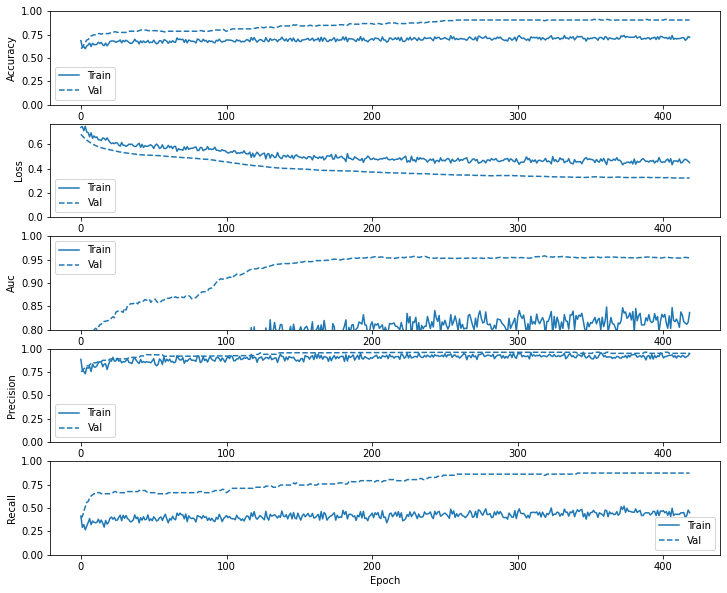

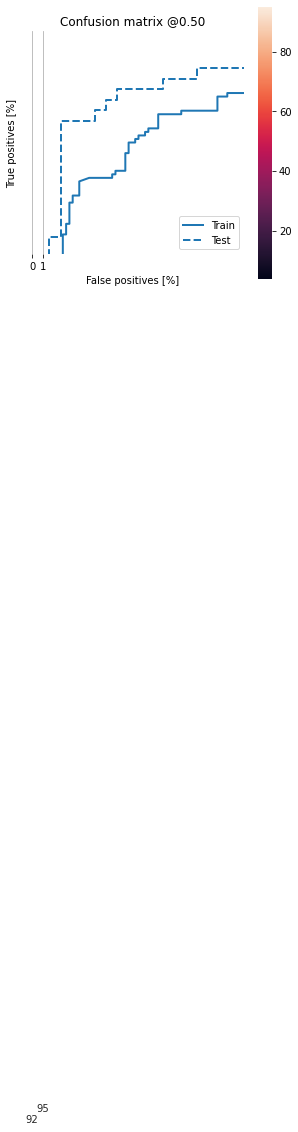

In [38]:
%%time
expId = 201
desc = str(expId) + " Classical Deep Learning" 

model_201, history_201 = runTheExperiments(expId, desc)


In [39]:
f.write("19_BotnetDga_Benchmarks - CPU n100 1layer - Device Noise Model ibmq_santiago - qiskit.aer - seed 123")
f.flush()